In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/datasets/advML/games_march2025.csv')

Mounted at /content/drive


#Data Inspection

In [3]:
print("Shape:", df.shape)
df.head()

Shape: (89618, 47)


,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,...,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,discount,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent
0,730,Counter-Strike 2,2012-08-21,0,0.00,1,"For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...",NaN,...,879,5174,350,0,1212356,"{'FPS': 90857, 'Shooter': 65397, 'Multiplayer'...",86,8632939,82,96473
1,578080,PUBG: BATTLEGROUNDS,2017-12-21,0,0.00,0,"LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...","LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...",Play PUBG: BATTLEGROUNDS for free. Land on str...,NaN,...,0,0,0,0,616738,"{'Survival': 14838, 'Shooter': 12727, 'Battle ...",59,2513842,68,16720
2,570,Dota 2,2013-07-09,0,0.00,2,"The most-played game on Steam. Every day, mill...","The most-played game on Steam. Every day, mill...","Every day, millions of players worldwide enter...",“A modern multiplayer masterpiece.” 9.5/10 – D...,...,1536,898,892,0,555977,"{'Free to Play': 59933, 'MOBA': 20158, 'Multip...",81,2452595,80,29366
3,271590,Grand Theft Auto V Legacy,2015-04-13,17,0.00,0,"When a young street hustler, a retired bank ro...","When a young street hustler, a retired bank ro...",Grand Theft Auto V for PC offers players the o...,NaN,...,771,7101,74,0,117698,"{'Open World': 32644, 'Action': 23539, 'Multip...",87,1803832,92,17517
4,359550,Tom Clancy's Rainbow Six® Siege,2015-12-01,17,3.99,9,Edition Comparison Ultimate Edition The Tom Cl...,“One of the best first-person shooters ever ma...,"Tom Clancy's Rainbow Six® Siege is an elite, t...",NaN,...,682,2434,306,80,89916,"{'FPS': 9831, 'PvP': 9162, 'e-sports': 9072, '...",84,1168020,76,12608


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89618 entries, 0 to 89617
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   appid                     89618 non-null  int64  
 1   name                      89618 non-null  object 
 2   release_date              89618 non-null  object 
 3   required_age              89618 non-null  int64  
 4   price                     89618 non-null  float64
 5   dlc_count                 89618 non-null  int64  
 6   detailed_description      89421 non-null  object 
 7   about_the_game            89398 non-null  object 
 8   short_description         89498 non-null  object 
 9   reviews                   10401 non-null  object 
 10  header_image              89618 non-null  object 
 11  website                   41114 non-null  object 
 12  support_url               44110 non-null  object 
 13  support_email             78798 non-null  object 
 14  window

In [5]:
missing = df.isna().sum()
missing_pct = (missing / len(df)) * 100

missing_table = pd.DataFrame({
    "missing_count": missing,
    "missing_pct": missing_pct
}).sort_values("missing_pct", ascending=False)

missing_table.head(15)

,missing_count,missing_pct
score_rank,89579,99.956482
metacritic_url,86071,96.042090
reviews,79217,88.394073
notes,72975,81.428954
website,48504,54.123056
support_url,45508,50.779977
support_email,10820,12.073467
about_the_game,220,0.245486
detailed_description,197,0.219822
short_description,120,0.133902


In [6]:
print("Duplicate rows:", df.duplicated().sum())
print("Duplicate appid:", df["appid"].duplicated().sum())

Duplicate rows: 0
Duplicate appid: 0


#Data Cleaning

In [7]:
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")

print("Null release_date:", df["release_date"].isna().sum())

df["release_year"] = df["release_date"].dt.year
df["release_age_years"] = (pd.Timestamp.today() - df["release_date"]).dt.days / 365.25

df[["release_date", "release_year", "release_age_years"]].head()

Null release_date: 0


,release_date,release_year,release_age_years
0,2012-08-21,2012,13.481177
1,2017-12-21,2017,8.147844
2,2013-07-09,2013,12.599589
3,2015-04-13,2015,10.839151
4,2015-12-01,2015,10.203970


In [8]:
def parse_owner_mid(x):
    if pd.isna(x):
        return np.nan

    x = str(x).replace(",", "").strip()

    if "-" not in x:
        return np.nan

    low, high = x.split("-")
    low = low.strip()
    high = high.strip()

    try:
        return (float(low) + float(high)) / 2
    except:
        return np.nan

df["owners_mid"] = df["estimated_owners"].apply(parse_owner_mid)

print("Null owners_mid:", df["owners_mid"].isna().sum())

df[["estimated_owners", "owners_mid"]].head(10)

Null owners_mid: 0


,estimated_owners,owners_mid
0,100000000 - 200000000,150000000.0
1,50000000 - 100000000,75000000.0
2,200000000 - 500000000,350000000.0
3,50000000 - 100000000,75000000.0
4,20000000 - 50000000,35000000.0
5,20000000 - 50000000,35000000.0
6,20000000 - 50000000,35000000.0
7,20000000 - 50000000,35000000.0
8,20000000 - 50000000,35000000.0
9,50000000 - 100000000,75000000.0


In [9]:
print("owners_mid min:", df["owners_mid"].min())
print("owners_mid max:", df["owners_mid"].max())

df["owners_mid"].describe()

owners_mid min: 0.0
owners_mid max: 350000000.0


,owners_mid
count,8.961800e+04
mean,1.011338e+05
std,1.677279e+06
min,0.000000e+00
25%,1.000000e+04
50%,1.000000e+04
75%,1.000000e+04
max,3.500000e+08


In [10]:
df[df["owners_mid"] == 0]["estimated_owners"].value_counts().head(10)

,count
estimated_owners,
0 - 0,8418


In [11]:
df["average_playtime_forever"].value_counts().head(10)

,count
average_playtime_forever,
0,81608
1,209
3,80
5,69
2,59
4,58
6,56
8,53
7,49


In [12]:
df_model = df.copy()

# drop free games
df_model = df_model[df_model["price"] > 0].copy()

# drop 0-0 owner games
df_model = df_model[df_model["owners_mid"] > 0].copy()

# drop 0 review games
df_model = df_model[df_model["num_reviews_total"] > 0].copy()

print("Original df shape:", df.shape)
print("Filtered df_model shape:", df_model.shape)

print("\nZero playtime count still remaining:", (df_model["average_playtime_forever"] == 0).sum())


Original df shape: (89618, 50)
Filtered df_model shape: (41140, 50)

Zero playtime count still remaining: 34354


In [13]:
n_original = len(df)

n_paid = (df["price"] > 0).sum()
n_paid_owners = ((df["price"] > 0) & (df["owners_mid"] > 0)).sum()
n_paid_owners_reviews = ((df["price"] > 0) & (df["owners_mid"] > 0) & (df["num_reviews_total"] > 0)).sum()

print("Original rows:", n_original)
print("Paid only:", n_paid)
print("Paid + owners_mid > 0:", n_paid_owners)
print("Paid + owners_mid > 0 + num_reviews_total > 0:", n_paid_owners_reviews)

Original rows: 89618
Paid only: 75458
Paid + owners_mid > 0: 74269
Paid + owners_mid > 0 + num_reviews_total > 0: 41140


#EDA

In [14]:
mean_price = df_model['price'].mean()
median_price = df_model['price'].median()

mean_positive = df_model['positive'].mean()
median_positive = df_model['positive'].median()

mean_negative = df_model['negative'].mean()
median_negative = df_model['negative'].median()

print(f"Mean Price: {mean_price:.2f}")
print(f"Median Price: {median_price:.2f}")
print(f"Mean Positive Reviews: {mean_positive:.2f}")
print(f"Median Positive Reviews: {median_positive:.2f}")
print(f"Mean Negative Reviews: {mean_negative:.2f}")
print(f"Median Negative Reviews: {median_negative:.2f}")

Mean Price: 9.93
Median Price: 6.99
Mean Positive Reviews: 2061.93
Median Positive Reviews: 49.00
Mean Negative Reviews: 290.60
Median Negative Reviews: 13.00


In [15]:
print(f"Games with price >= median price ({median_price:.2f}):")
display(df_model.query(f'price >= {median_price}'))

Games with price >= median price (6.99):


,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,...,discount,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent,release_year,release_age_years,owners_mid
6,105600,Terraria,2011-05-16,0,9.99,2,"Dig, Fight, Explore, Build: The very world is ...","Dig, Fight, Explore, Build: The very world is ...","Dig, fight, explore, build! Nothing is impossi...",NaN,...,0,30516,"{'Open World Survival Craft': 16365, 'Sandbox'...",97,1102434,96,8860,2011,14.748802,35000000.0
7,252490,Rust,2018-02-08,0,39.99,4,The only aim in Rust is to survive. Everything...,The only aim in Rust is to survive. Everything...,The only aim in Rust is to survive. Everything...,"“Rust is one of the cruelest games on Steam, a...",...,0,200902,"{'Survival': 18592, 'Crafting': 11822, 'Multip...",87,993856,87,14960,2018,8.013689,35000000.0
10,2358720,Black Myth: Wukong,2024-08-19,13,59.99,2,Digital Deluxe Edition The Black Myth: Wukong ...,Black Myth: Wukong is an action RPG rooted in ...,Black Myth: Wukong is an action RPG rooted in ...,NaN,...,0,35990,"{'Mythology': 9421, 'Action RPG': 7720, 'Actio...",96,825621,94,6139,2024,1.486653,75000000.0
11,292030,The Witcher 3: Wild Hunt,2015-05-18,17,39.99,22,DISCOVER THE STORY BEFORE THE WITCHER IV About...,One of the most acclaimed RPGs of all time. No...,"You are Geralt of Rivia, mercenary monster sla...",“ONE OF THE BEST GAMES EVER MADE” 10/10 – Game...,...,0,15129,"{'Open World': 12704, 'RPG': 10744, 'Story Ric...",96,751939,95,4228,2015,10.743326,15000000.0
12,1245620,ELDEN RING,2022-02-24,16,59.99,2,ELDEN RING Shadow of the Erdtree Edition ELDEN...,THE CRITICALLY ACCLAIMED FANTASY ACTION RPG Ri...,THE CRITICALLY ACCLAIMED FANTASY ACTION RPG. R...,“Put a ring on it.” 10/10 – IGN “An unmissable...,...,0,46121,"{'Souls-like': 6823, 'Open World': 4941, 'Dark...",92,749606,93,6753,2022,3.969884,35000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53182,3145860,Devils Adventure,2024-08-19,0,9.99,0,STORY: Player controls Devil Character in this...,STORY: Player controls Devil Character in this...,2.5d Platformer where you control devil charac...,NaN,...,0,0,"{'Casual': 72, 'Adventure': 66, 'Sandbox': 43,...",90,10,-1,-1,2024,1.486653,10000.0
53184,838160,Trail Breaking,2018-06-24,0,6.99,0,Trail Breaking is a First-Person Adventure/Puz...,Trail Breaking is a First-Person Adventure/Puz...,Trail Breaking is a First-Person Adventure/Puz...,NaN,...,0,0,"{'Adventure': 21, 'Indie': 21, 'Casual': 21, '...",50,10,-1,-1,2018,7.641342,10000.0
53189,2292440,inRun,2024-09-24,0,14.99,0,Add inRun to your favorite list and follow us!...,"Challenging the concept of traditional racing,...",Experience the magic of classic arcade racing ...,NaN,...,0,0,"{'Racing': 463, 'Casual': 457, 'Simulation': 4...",50,10,-1,-1,2024,1.388090,10000.0
53193,2895140,shock wave,2024-04-13,0,29.99,0,"On the Silent Night of All Saints, monsters co...","On the Silent Night of All Saints, monsters co...","On the Silent Night of All Saints, monsters co...",NaN,...,0,0,"{'RPG': 63, 'Action-Adventure': 37, 'Mystery D...",100,10,-1,-1,2024,1.837098,10000.0


In [16]:
print(f"Games with positive reviews >= mean positive reviews ({mean_positive:.2f}) and price >= median price ({median_price:.2f}):")
display(df_model.query(f'`positive` >= {mean_positive} and price >= {median_price}'))

Games with positive reviews >= mean positive reviews (2061.93) and price >= median price (6.99):


,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,...,discount,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent,release_year,release_age_years,owners_mid
6,105600,Terraria,2011-05-16,0,9.99,2,"Dig, Fight, Explore, Build: The very world is ...","Dig, Fight, Explore, Build: The very world is ...","Dig, fight, explore, build! Nothing is impossi...",NaN,...,0,30516,"{'Open World Survival Craft': 16365, 'Sandbox'...",97,1102434,96,8860,2011,14.748802,35000000.0
7,252490,Rust,2018-02-08,0,39.99,4,The only aim in Rust is to survive. Everything...,The only aim in Rust is to survive. Everything...,The only aim in Rust is to survive. Everything...,"“Rust is one of the cruelest games on Steam, a...",...,0,200902,"{'Survival': 18592, 'Crafting': 11822, 'Multip...",87,993856,87,14960,2018,8.013689,35000000.0
10,2358720,Black Myth: Wukong,2024-08-19,13,59.99,2,Digital Deluxe Edition The Black Myth: Wukong ...,Black Myth: Wukong is an action RPG rooted in ...,Black Myth: Wukong is an action RPG rooted in ...,NaN,...,0,35990,"{'Mythology': 9421, 'Action RPG': 7720, 'Actio...",96,825621,94,6139,2024,1.486653,75000000.0
11,292030,The Witcher 3: Wild Hunt,2015-05-18,17,39.99,22,DISCOVER THE STORY BEFORE THE WITCHER IV About...,One of the most acclaimed RPGs of all time. No...,"You are Geralt of Rivia, mercenary monster sla...",“ONE OF THE BEST GAMES EVER MADE” 10/10 – Game...,...,0,15129,"{'Open World': 12704, 'RPG': 10744, 'Story Ric...",96,751939,95,4228,2015,10.743326,15000000.0
12,1245620,ELDEN RING,2022-02-24,16,59.99,2,ELDEN RING Shadow of the Erdtree Edition ELDEN...,THE CRITICALLY ACCLAIMED FANTASY ACTION RPG Ri...,THE CRITICALLY ACCLAIMED FANTASY ACTION RPG. R...,“Put a ring on it.” 10/10 – IGN “An unmissable...,...,0,46121,"{'Souls-like': 6823, 'Open World': 4941, 'Dark...",92,749606,93,6753,2022,3.969884,35000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8487,351940,The Descendant,2016-03-24,0,14.99,0,WISHLIST NOW About the Game THE DESCENDANT is ...,THE DESCENDANT is a five part episodic adventu...,"In THE DESCENDANT, the end of the world is onl...",NaN,...,0,13,"{'Adventure': 8423, 'Point & Click': 113, 'Cas...",77,564,-1,-1,2016,9.891855,3500000.0
8597,994140,Lightmatter,2020-01-15,0,19.99,0,"A Letter from Virgil, CEO, Lightmatter Technol...",An Homage to First Person Puzzlers Play Tunnel...,A first-person puzzler where shadows kill you....,“Those who enjoy puzzle games will find plenty...,...,0,4,"{'Logic': 195, 'Indie': 167, 'Adventure': 163,...",94,553,86,15,2020,6.080767,350000.0
8666,555000,GOAT OF DUTY,2019-07-10,0,9.99,3,It all started with a freak nuclear accident t...,It all started with a freak nuclear accident t...,Goat of Duty is a fast-paced multiplayer shoot...,“It's worth a go if you like your fast-paced P...,...,40,2,"{'Early Access': 525, 'FPS': 477, 'Multiplayer...",89,545,-1,-1,2019,6.598220,150000.0
12592,435790,10 Second Ninja X,2016-07-19,0,9.99,0,"10 SECOND NINJA X is a shockingly fast, overwh...","10 SECOND NINJA X is a shockingly fast, overwh...",10 SECOND NINJA X is a hardcore sidescroller. ...,NaN,...,0,4,"{'Action': 81, 'Indie': 72, 'Platformer': 59, ...",85,267,-1,-1,2016,9.571526,750000.0


In [17]:
print(f"Games with negative reviews > mean negative reviews ({mean_negative:.2f}), price >= median price ({median_price:.2f}), and positive reviews < mean positive reviews ({mean_positive:.2f}):")
display(df_model.query(f'`negative` > {mean_negative} and price >= {median_price} and `positive` < {mean_positive}'))

Games with negative reviews > mean negative reviews (290.60), price >= median price (6.99), and positive reviews < mean positive reviews (2061.93):


,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,...,discount,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent,release_year,release_age_years,owners_mid
1837,2446550,STAR WARS™: Battlefront Classic Collection,2024-03-13,0,35.01,0,Fight in iconic battles from across the STAR W...,Fight in iconic battles from across the STAR W...,"Play the classic STAR WARS™ Battlefront games,...",NaN,...,0,32,"{'Action': 568, 'Space': 556, 'Sci-fi': 548, '...",21,6972,42,21,2024,1.921971,750000.0
1852,1962660,Call of Duty®: Modern Warfare® II,2022-10-27,17,69.99,0,Welcome to the new era of Call of Duty®. Call ...,Welcome to the new era of Call of Duty®. Call ...,Call of Duty®: Modern Warfare® II drops player...,NaN,...,0,0,"{'Action': 151, 'FPS': 105, 'Singleplayer': 95...",21,6919,43,136,2022,3.299110,10000.0
2436,1236300,Resident Evil Re:Verse,2022-10-27,0,39.99,9,Resident Evil Re:Verse IMPORTANT NOTICE: Servi...,Beloved Resident Evil characters clash in a fi...,Beloved Resident Evil characters clash in a fi...,NaN,...,0,12,"{'Action': 246, 'PvP': 240, 'Third-Person Shoo...",33,4511,39,110,2022,3.299110,350000.0
2713,1220840,Retirement Simulator,2022-04-19,0,13.99,0,"Dear retirees, welcome to Retirement Simulator...","Dear retirees, welcome to Retirement Simulator...",Retirement Simulator is a game that simulates ...,NaN,...,0,0,"{'Early Access': 221, 'Simulation': 200, 'RPG'...",35,3826,-1,-1,2022,3.822040,150000.0
2983,246090,Spacebase DF-9,2014-10-27,0,9.99,0,"In Spacebase DF-9, you'll build a home among t...","In Spacebase DF-9, you'll build a home among t...","In Spacebase DF-9, you'll build a home among t...",NaN,...,0,2,"{'Simulation': 164, 'Space': 148, 'Base-Buildi...",17,3322,-1,-1,2014,11.299110,350000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25189,207650,A Virus Named TOM,2012-08-01,0,9.99,2,A perfect place. A city without traffic. A dog...,A perfect place. A city without traffic. A dog...,Hack your way through brain scrambling puzzles...,'its clever take on puzzle gameplay is likely ...,...,0,0,"{'Indie': 88, 'Puzzle': 87, 'Action': 53, 'Str...",72,62,-1,-1,2012,13.535934,350000.0
25699,3062930,Unplagued,2024-10-10,0,7.99,0,"With a team of up to 4 companions, purge the p...","With a team of up to 4 companions, purge the p...",Play as plague doctors with your friends in th...,NaN,...,0,28,"{'Online Co-Op': 411, 'Horror': 408, 'Multipla...",42,59,-1,-1,2024,1.344285,350000.0
29003,315330,All Guns On Deck,2015-08-28,0,12.99,0,"The vast horizons are full of pirates, vagabon...","The vast horizons are full of pirates, vagabon...","All Guns On Deck is a naval strategy, real tim...",“All Guns On Deck has the potential to be a cl...,...,0,1,"{'Strategy': 122, 'Indie': 120, 'Casual': 119,...",17,45,-1,-1,2015,10.464066,75000.0
30559,414160,Nubarron: The adventure of an unlucky gnome,2020-01-30,0,9.99,0,A Gorgeous Digital Painted Fantasy World An Am...,A Gorgeous Digital Painted Fantasy World An Am...,Guide Gnome across the dangers of this twisted...,NaN,...,0,0,"{'Indie': 59, 'Adventure': 59, 'Platformer': 4...",71,39,-1,-1,2020,6.039699,75000.0


In [18]:
main_features = [
    "price",
    "discount",
    "owners_mid",
    "num_reviews_total",
    "pct_pos_total",
    "peak_ccu",
    "average_playtime_forever",
    "release_age_years"
]

df_model[main_features].describe().T

,count,mean,std,min,25%,50%,75%,max
price,41140.0,9.934616,1.081835e+01,0.490000,2.990000,6.990000,13.99000,1.999900e+02
discount,41140.0,7.658070,2.104296e+01,0.000000,0.000000,0.000000,0.00000,9.500000e+01
owners_mid,41140.0,143891.954302,1.177100e+06,10000.000000,10000.000000,10000.000000,35000.00000,7.500000e+07
num_reviews_total,41140.0,1907.783884,2.001739e+04,10.000000,20.000000,55.000000,250.00000,1.168020e+06
pct_pos_total,41140.0,77.208264,1.789944e+01,0.000000,68.000000,81.000000,91.00000,1.000000e+02
peak_ccu,41140.0,121.846743,4.091588e+03,0.000000,0.000000,0.000000,2.00000,7.032360e+05
average_playtime_forever,41140.0,221.735367,1.003447e+04,0.000000,0.000000,0.000000,0.00000,1.462997e+06
release_age_years,41140.0,5.665173,3.329057e+00,0.930869,2.724162,5.253936,8.19165,2.862423e+01


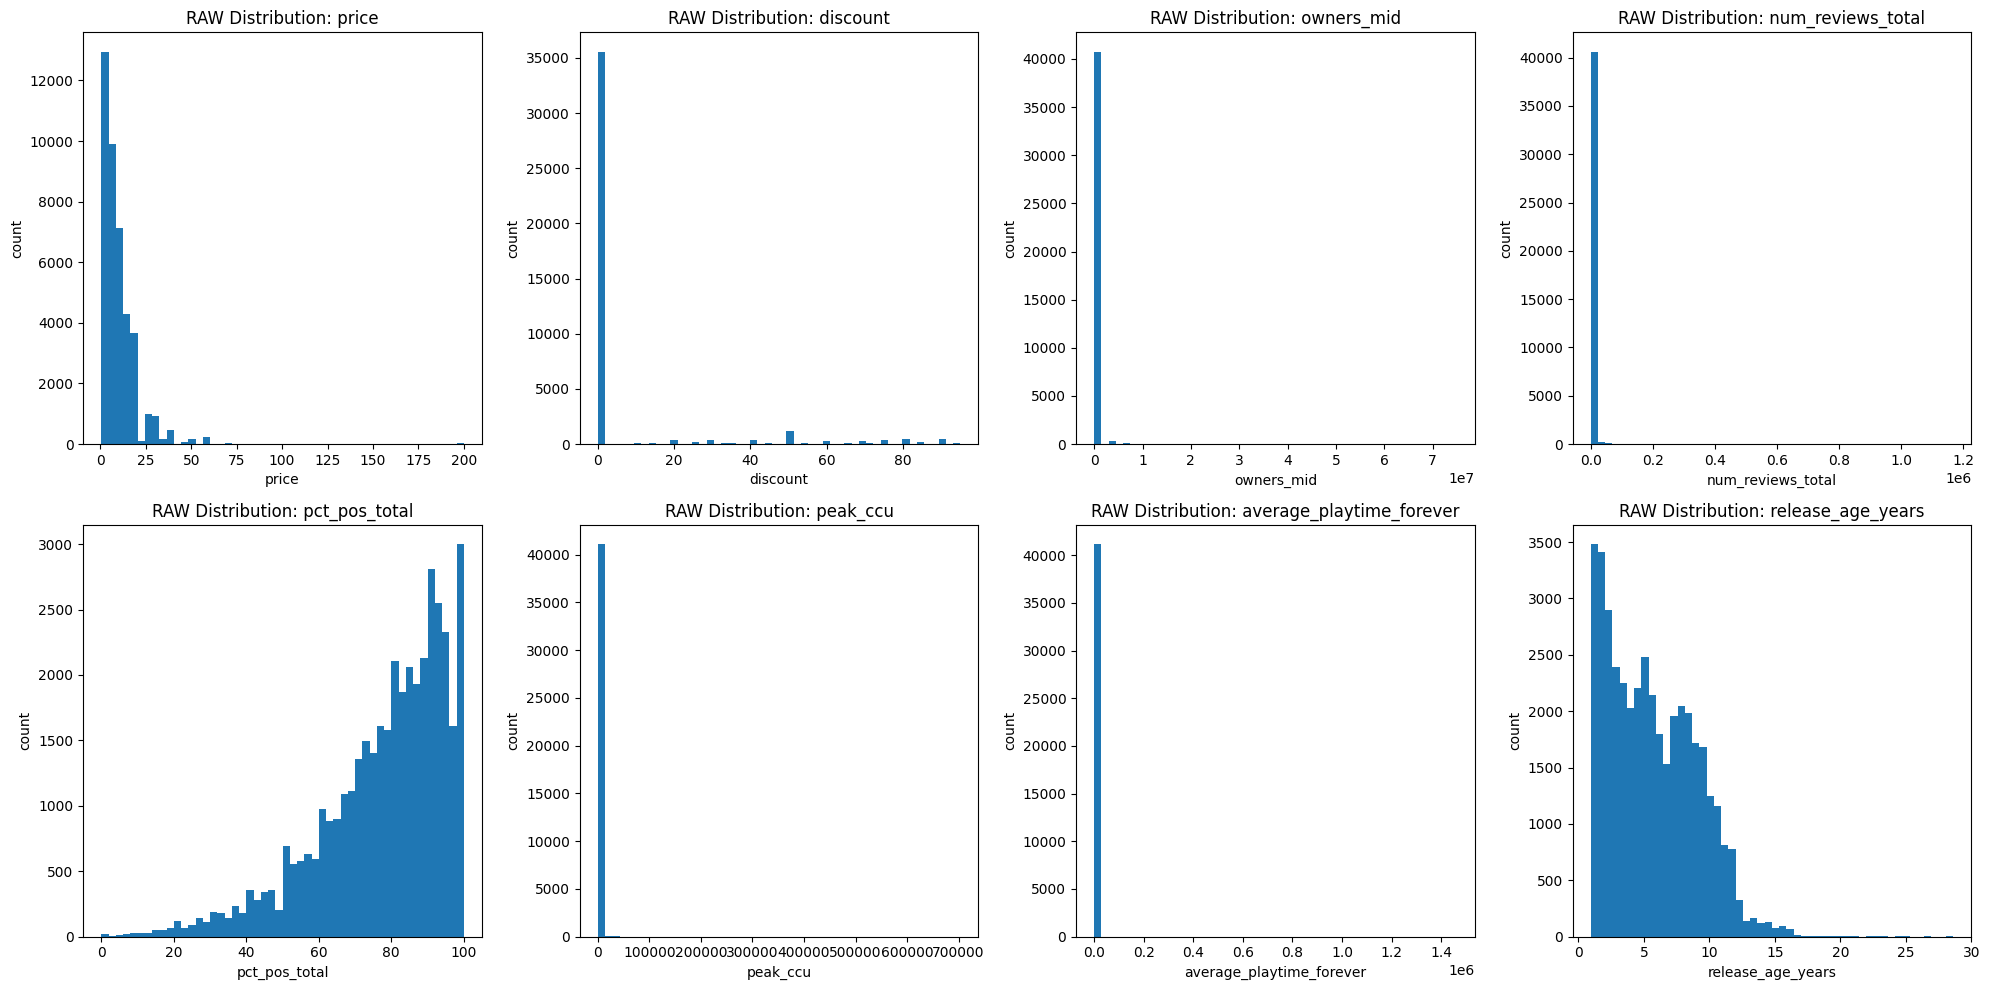

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(main_features):
    axes[i].hist(df_model[col].dropna(), bins=50)
    axes[i].set_title(f"RAW Distribution: {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("count")

plt.tight_layout()
plt.show()

In [20]:
df_model["log_owners"] = np.log1p(df_model["owners_mid"])
df_model["log_reviews"] = np.log1p(df_model["num_reviews_total"])
df_model["log_peak_ccu"] = np.log1p(df_model["peak_ccu"])
df_model["log_playtime_forever"] = np.log1p(df_model["average_playtime_forever"])

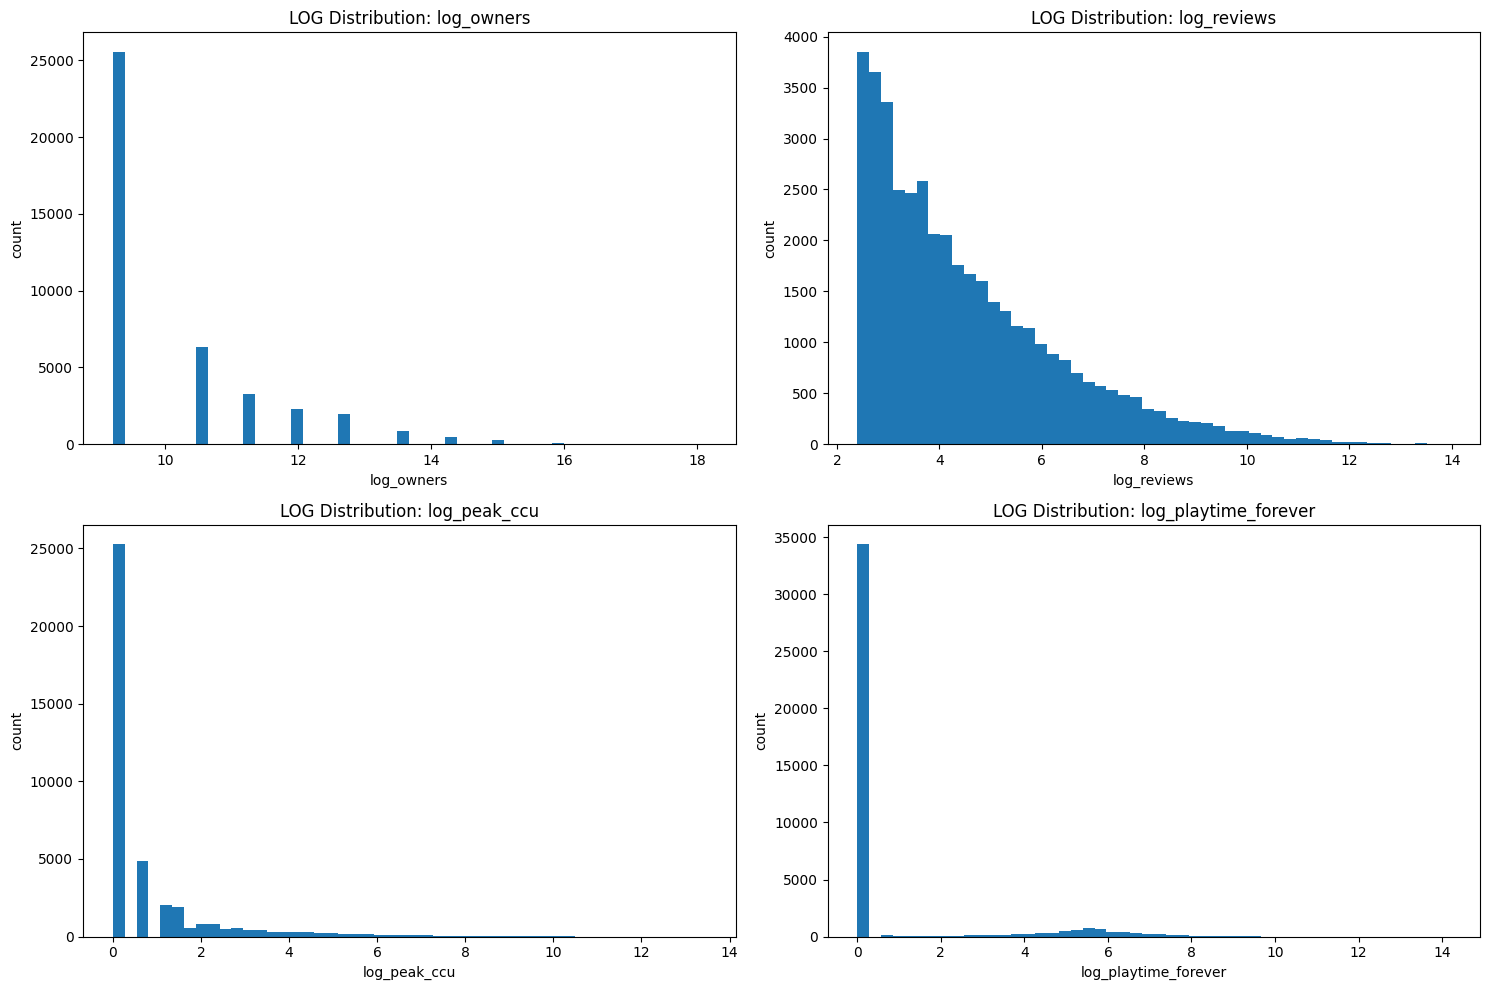

In [21]:
log_features = ["log_owners", "log_reviews", "log_peak_ccu", "log_playtime_forever"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(log_features):
    axes[i].hist(df_model[col].dropna(), bins=50)
    axes[i].set_title(f"LOG Distribution: {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("count")

plt.tight_layout()
plt.show()

In [22]:
df_model["playtime_missing_or_zero"] = (df_model["average_playtime_forever"] == 0).astype(int)

#Feature Selection

In [23]:
needed_cols = [
    "price", "discount", "pct_pos_total", "release_age_years",
    "owners_mid", "num_reviews_total", "peak_ccu", "average_playtime_forever",
    "log_owners", "log_reviews", "log_peak_ccu", "log_playtime_forever",
    "playtime_missing_or_zero"
]

missing = [c for c in needed_cols if c not in df_model.columns]
missing

[]

In [24]:
df_base = df_model.copy()

df_base = df_base[
    (df_base["price"] > 0) &
    (df_base["pct_pos_total"].between(0, 100)) &
    (df_base["discount"].between(0, 100))
].copy()

print("df_model:", df_model.shape)
print("df_base :", df_base.shape)

df_model: (41140, 55)
df_base : (41140, 55)


In [25]:
AVG_HOURS_THRESHOLD = 5000
REV_LOW = 750
OWN_LOW = 750

df_base["avg_hours"] = df_base["average_playtime_forever"] / 60

mask_high_hours = df_base["avg_hours"] > AVG_HOURS_THRESHOLD
mask_low_engagement = (df_base["num_reviews_total"] <= REV_LOW) | (df_base["owners_mid"] <= OWN_LOW)
mask_suspicious = mask_high_hours & mask_low_engagement

print("Suspicious rows:", int(mask_suspicious.sum()))
print("Before:", df_base.shape)

df_base = df_base[~mask_suspicious].copy()

print("After:", df_base.shape)

Suspicious rows: 4
Before: (41140, 56)
After: (41136, 56)


In [26]:
df_base = df_base.copy()

# Raw ratios
df_base["hours_per_dollar"] = df_base["average_playtime_forever"] / df_base["price"]
df_base["reviews_per_dollar"] = df_base["num_reviews_total"] / df_base["price"]
df_base["owners_per_dollar"] = df_base["owners_mid"] / df_base["price"]

# Approx positive reviews count
df_base["positive_est"] = (df_base["pct_pos_total"] / 100) * df_base["num_reviews_total"]
df_base["positive_per_dollar"] = df_base["positive_est"] / df_base["price"]

# Log ratios
df_base["log_hours_per_dollar"] = np.log1p(df_base["hours_per_dollar"])
df_base["log_reviews_per_dollar"] = np.log1p(df_base["reviews_per_dollar"])
df_base["log_owners_per_dollar"] = np.log1p(df_base["owners_per_dollar"])
df_base["log_positive_per_dollar"] = np.log1p(df_base["positive_per_dollar"])

df_base[[
    "hours_per_dollar", "reviews_per_dollar", "owners_per_dollar", "positive_per_dollar",
    "log_hours_per_dollar", "log_reviews_per_dollar", "log_owners_per_dollar", "log_positive_per_dollar"
]].describe().T

,count,mean,std,min,25%,50%,75%,max
hours_per_dollar,41136.0,23.660840,955.263023,0.000000,0.000000,0.000000,0.000000,1.621249e+05
reviews_per_dollar,41136.0,179.518831,2412.008813,0.050003,3.781980,11.237060,42.125009,2.927368e+05
owners_per_dollar,41136.0,20300.424580,133921.780585,50.002500,1167.055685,3344.481605,10101.010101,1.170569e+07
positive_per_dollar,41136.0,155.900946,2151.267835,0.000000,2.766499,8.386158,32.777778,2.458989e+05
log_hours_per_dollar,41136.0,0.540207,1.358918,0.000000,0.000000,0.000000,0.000000,1.199613e+01
log_reviews_per_dollar,41136.0,2.841522,1.666120,0.048793,1.564855,2.504469,3.764103,1.258703e+01
log_owners_per_dollar,41136.0,8.258140,1.527979,3.931875,7.063096,8.115366,9.220490,1.627559e+01
log_positive_per_dollar,41136.0,2.604094,1.680941,0.000000,1.326146,2.239236,3.519803,1.241268e+01


In [27]:
df_pt = df_base[df_base["average_playtime_forever"] > 0].copy()

print("df_base (all):", df_base.shape)
print("df_pt (playtime>0):", df_pt.shape)
print("playtime==0 count in df_base:", (df_base["average_playtime_forever"] == 0).sum())

df_base (all): (41136, 65)
df_pt (playtime>0): (6782, 65)
playtime==0 count in df_base: 34354


1. Balanced feature set (main)

In [28]:
features_balanced = [
    "price",
    "discount",
    "release_age_years",
    "pct_pos_total",
    "log_owners",
    "log_reviews",
    "log_peak_ccu",
    "log_playtime_forever",
    "playtime_missing_or_zero"
]

2. Ratios feature set (value-for-money)

In [29]:
features_ratios = [
    "price",
    "discount",
    "release_age_years",
    "pct_pos_total",
    "log_hours_per_dollar",
    "log_reviews_per_dollar",
    "log_owners_per_dollar",
    "log_positive_per_dollar",
    "playtime_missing_or_zero"
]

3. Minimal baseline (simple comparison)

In [30]:
features_minimal = [
    "price",
    "pct_pos_total",
    "log_reviews",
    "release_age_years"
]

In [31]:
# X1 = Balanced (ALL)
X1 = df_base[features_balanced].copy()

# X2 = Balanced (PLAYTIME>0)
X2 = df_pt[features_balanced].copy()

# X3 = Ratios (ALL)
X3 = df_base[features_ratios].copy()

# X4 = Ratios (PLAYTIME>0)
X4 = df_pt[features_ratios].copy()

# X5 = Minimal (ALL)
X5 = df_base[features_minimal].copy()

# X6 = Minimal (PLAYTIME>0)
X6 = df_pt[features_minimal].copy()

print("X1 Balanced ALL:", X1.shape)
print("X2 Balanced PT :", X2.shape)
print("X3 Ratios ALL  :", X3.shape)
print("X4 Ratios PT   :", X4.shape)
print("X5 Minimal ALL :", X5.shape)
print("X6 Minimal PT  :", X6.shape)

X1 Balanced ALL: (41136, 9)
X2 Balanced PT : (6782, 9)
X3 Ratios ALL  : (41136, 9)
X4 Ratios PT   : (6782, 9)
X5 Minimal ALL : (41136, 4)
X6 Minimal PT  : (6782, 4)


In [32]:
def nan_report(X, name):
    total = int(X.isna().sum().sum())
    top = X.isna().sum().sort_values(ascending=False).head(8)
    print(f"{name}: total NaNs = {total}")
    display(top)

nan_report(X1, "X1")
nan_report(X2, "X2")
nan_report(X3, "X3")
nan_report(X4, "X4")
nan_report(X5, "X5")
nan_report(X6, "X6")

X1: total NaNs = 0


,0
price,0
discount,0
release_age_years,0
pct_pos_total,0
log_owners,0
log_reviews,0
log_peak_ccu,0
log_playtime_forever,0


X2: total NaNs = 0


,0
price,0
discount,0
release_age_years,0
pct_pos_total,0
log_owners,0
log_reviews,0
log_peak_ccu,0
log_playtime_forever,0


X3: total NaNs = 0


,0
price,0
discount,0
release_age_years,0
pct_pos_total,0
log_hours_per_dollar,0
log_reviews_per_dollar,0
log_owners_per_dollar,0
log_positive_per_dollar,0


X4: total NaNs = 0


,0
price,0
discount,0
release_age_years,0
pct_pos_total,0
log_hours_per_dollar,0
log_reviews_per_dollar,0
log_owners_per_dollar,0
log_positive_per_dollar,0


X5: total NaNs = 0


,0
price,0
pct_pos_total,0
log_reviews,0
release_age_years,0


X6: total NaNs = 0


,0
price,0
pct_pos_total,0
log_reviews,0
release_age_years,0


In [33]:
summary = pd.DataFrame({
    "Experiment": [
        "X1 Balanced (ALL)",
        "X2 Balanced (playtime>0)",
        "X3 Ratios (ALL)",
        "X4 Ratios (playtime>0)",
        "X5 Minimal (ALL)",
        "X6 Minimal (playtime>0)"
    ],
    "Rows": [len(X1), len(X2), len(X3), len(X4), len(X5), len(X6)],
    "Cols": [X1.shape[1], X2.shape[1], X3.shape[1], X4.shape[1], X5.shape[1], X6.shape[1]]
})
summary

,Experiment,Rows,Cols
0,X1 Balanced (ALL),41136,9
1,X2 Balanced (playtime>0),6782,9
2,X3 Ratios (ALL),41136,9
3,X4 Ratios (playtime>0),6782,9
4,X5 Minimal (ALL),41136,4
5,X6 Minimal (playtime>0),6782,4


#PCA

X1 Balanced (ALL)
Rows: 41136 | Features: 9
PCs for 90% variance: 6
PCs for 95% variance: 7
X2 Balanced (playtime>0)
Rows: 6782 | Features: 9
PCs for 90% variance: 6
PCs for 95% variance: 6
X3 Ratios (ALL)
Rows: 41136 | Features: 9
PCs for 90% variance: 6
PCs for 95% variance: 6
X4 Ratios (playtime>0)
Rows: 6782 | Features: 9
PCs for 90% variance: 5
PCs for 95% variance: 6
X5 Minimal (ALL)
Rows: 41136 | Features: 4
PCs for 90% variance: 4
PCs for 95% variance: 4
X6 Minimal (playtime>0)
Rows: 6782 | Features: 4
PCs for 90% variance: 4
PCs for 95% variance: 4


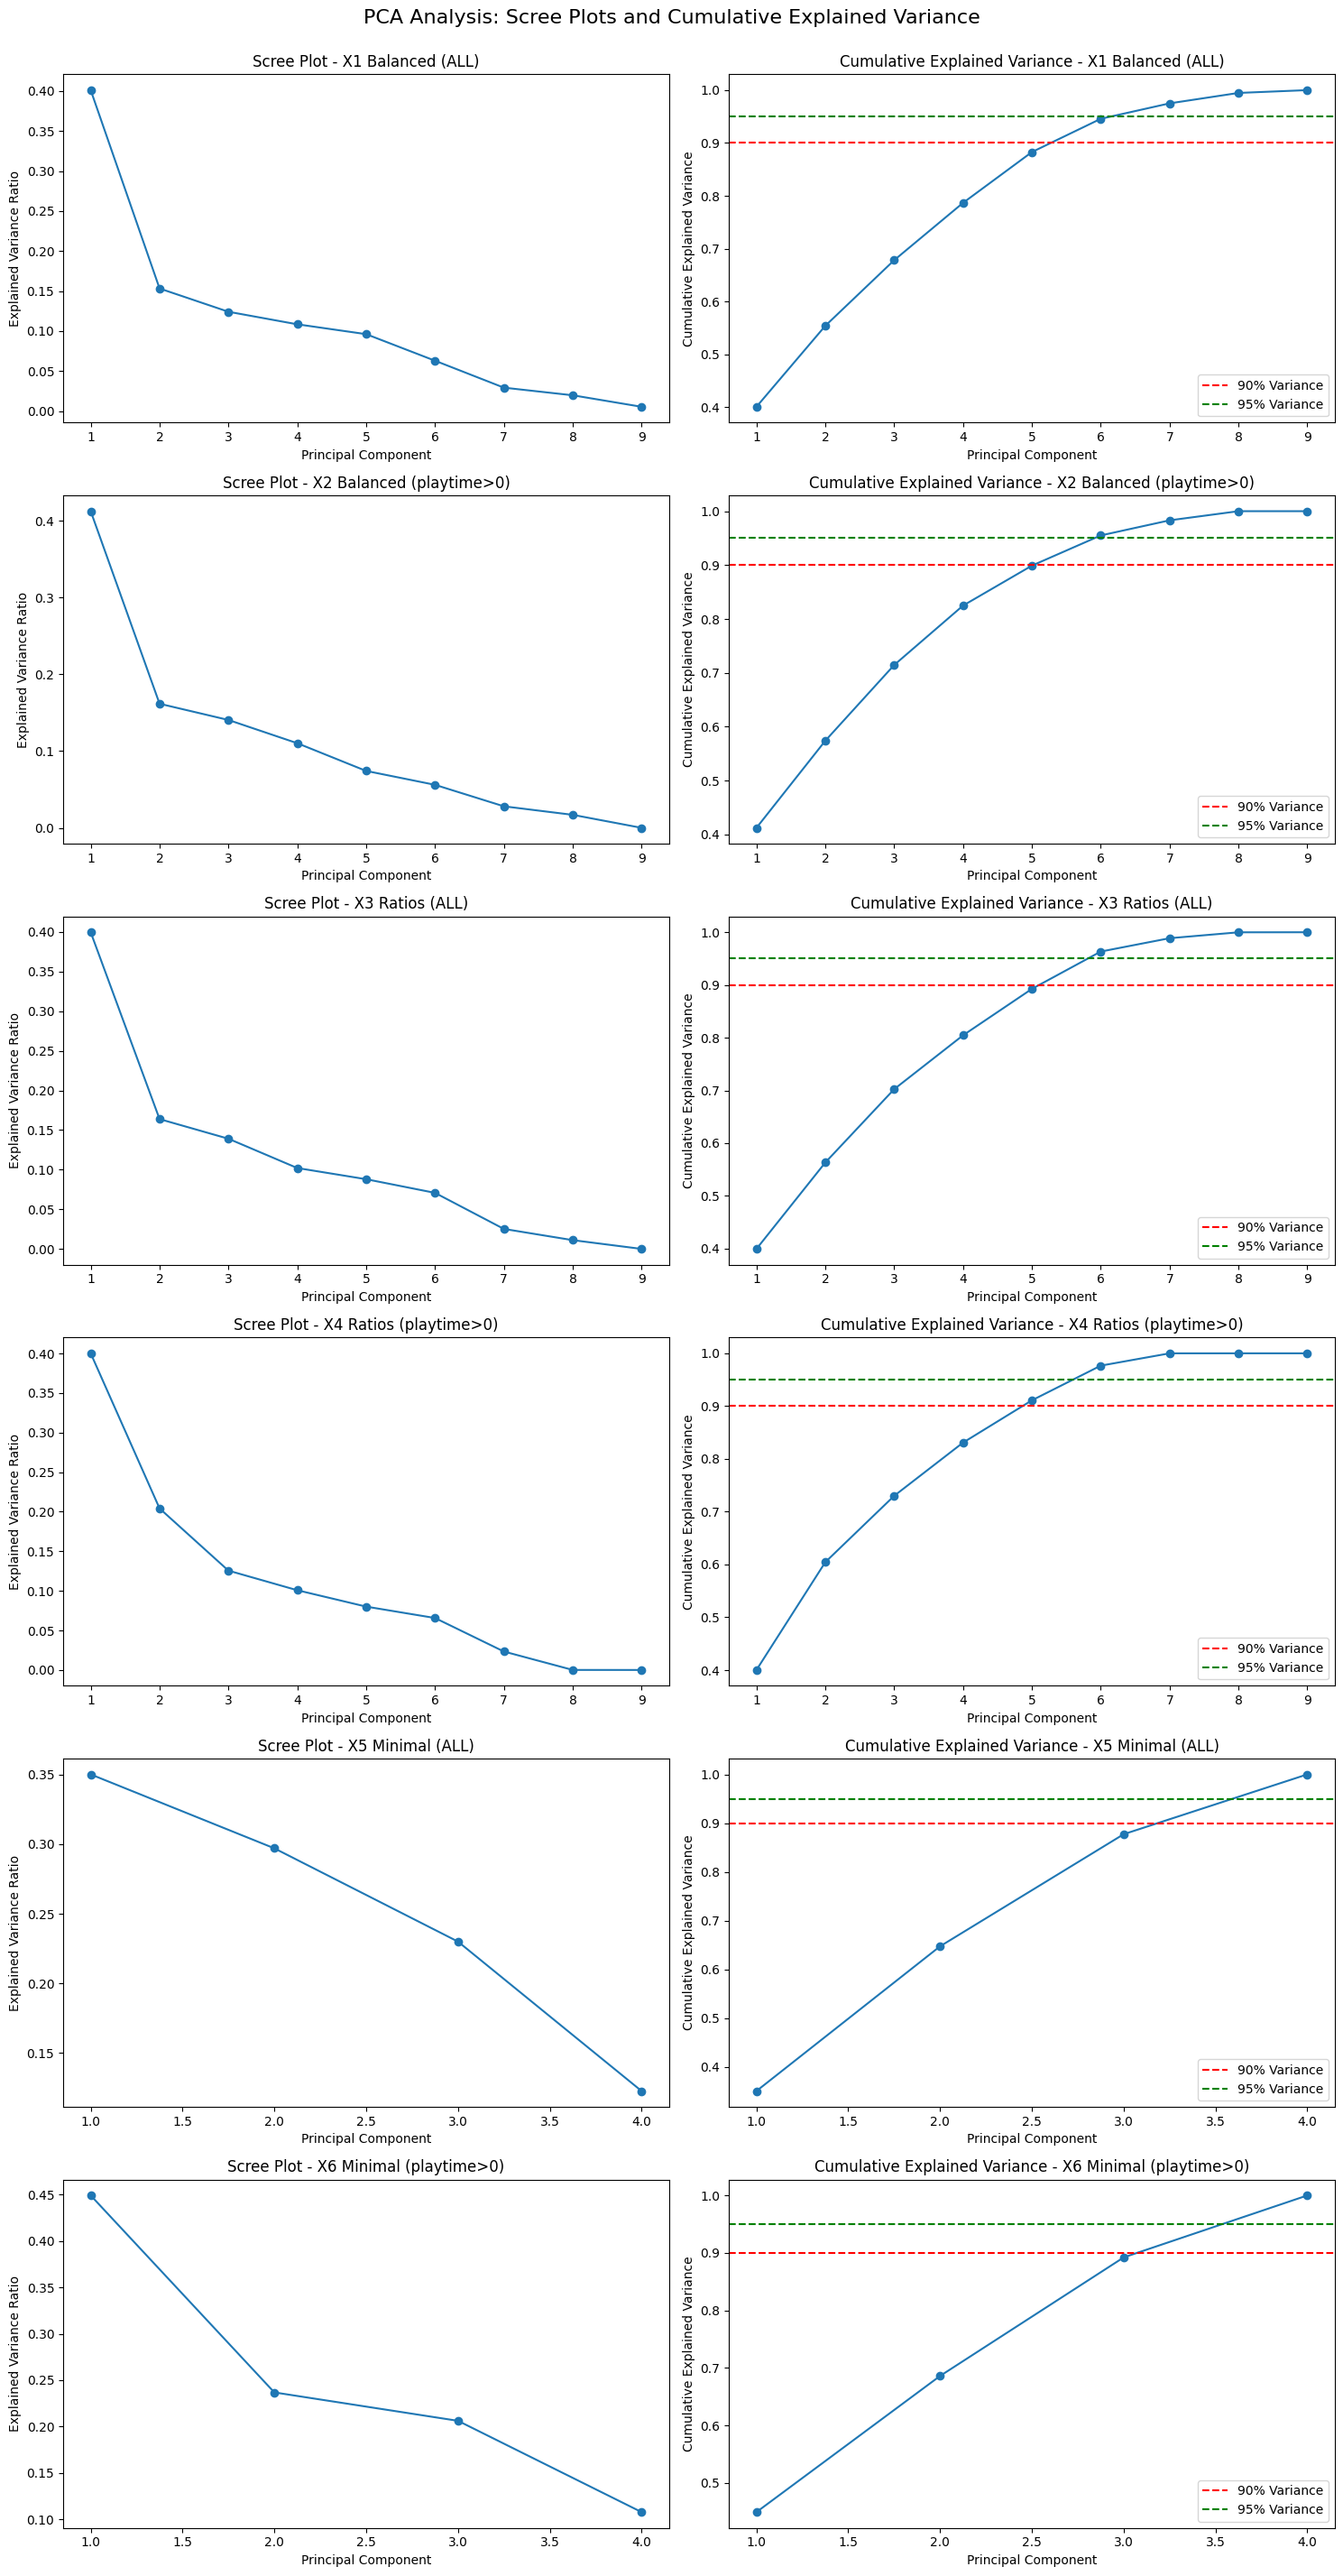

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def run_pca(X, name):
    # 1) Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2) PCA full
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    explained = pca.explained_variance_ratio_
    cum = explained.cumsum()

    pcs_90 = int((cum >= 0.90).argmax() + 1)
    pcs_95 = int((cum >= 0.95).argmax() + 1)

    # 3) Print summary
    print("="*60)
    print(name)
    print("Rows:", X.shape[0], "| Features:", X.shape[1])
    print("PCs for 90% variance:", pcs_90)
    print("PCs for 95% variance:", pcs_95)

    # 4) Return useful objects including explained and cumulative variance for plotting later
    return {
        "name": name,
        "rows": X.shape[0],
        "features": X.shape[1],
        "pcs_90": pcs_90,
        "pcs_95": pcs_95,
        "scaler": scaler,
        "pca": pca,
        "X_scaled": X_scaled,
        "X_pca": X_pca,
        "explained": explained,
        "cumulative": cum
    }

# Run PCA for all 6 datasets
results_pca = []
results_pca.append(run_pca(X1, "X1 Balanced (ALL)"))
results_pca.append(run_pca(X2, "X2 Balanced (playtime>0)"))
results_pca.append(run_pca(X3, "X3 Ratios (ALL)"))
results_pca.append(run_pca(X4, "X4 Ratios (playtime>0)"))
results_pca.append(run_pca(X5, "X5 Minimal (ALL)"))
results_pca.append(run_pca(X6, "X6 Minimal (playtime>0)"))

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 30))
fig.suptitle("PCA Analysis: Scree Plots and Cumulative Explained Variance", fontsize=16)
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, res in enumerate(results_pca):
    name = res["name"]
    explained = res["explained"]
    cum = res["cumulative"]
    pcs_90 = res["pcs_90"]
    pcs_95 = res["pcs_95"]

    # Scree Plot
    axes[i, 0].plot(range(1, len(explained)+1), explained, marker="o")
    axes[i, 0].set_title(f"Scree Plot - {name}")
    axes[i, 0].set_xlabel("Principal Component")
    axes[i, 0].set_ylabel("Explained Variance Ratio")

    # Cumulative Explained Variance
    axes[i, 1].plot(range(1, len(cum)+1), cum, marker="o")
    axes[i, 1].axhline(0.90, linestyle="--", color='red', label='90% Variance')
    axes[i, 1].axhline(0.95, linestyle="--", color='green', label='95% Variance')
    axes[i, 1].set_title(f"Cumulative Explained Variance - {name}")
    axes[i, 1].set_xlabel("Principal Component")
    axes[i, 1].set_ylabel("Cumulative Explained Variance")
    axes[i, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [88]:
for res in results_pca:
    print("\n---", res["name"], "---")

    explained_df = pd.DataFrame({
        'Principal Component': range(1, len(res["explained"]) + 1),
        'Explained Variance (%)': (res["explained"] * 100).round(2),
        'Cumulative Explained Variance (%)': (res["cumulative"] * 100).round(2)
    })
    display(explained_df)


--- X1 Balanced (ALL) ---


,Principal Component,Explained Variance (%),Cumulative Explained Variance (%)
0,1,40.11,40.11
1,2,15.32,55.43
2,3,12.41,67.83
3,4,10.84,78.68
4,5,9.61,88.28
5,6,6.29,94.58
6,7,2.92,97.50
7,8,1.97,99.47
8,9,0.53,100.00



--- X2 Balanced (playtime>0) ---


,Principal Component,Explained Variance (%),Cumulative Explained Variance (%)
0,1,41.24,41.24
1,2,16.16,57.41
2,3,14.05,71.46
3,4,11.02,82.48
4,5,7.41,89.90
5,6,5.60,95.50
6,7,2.80,98.30
7,8,1.70,100.00
8,9,0.00,100.00



--- X3 Ratios (ALL) ---


,Principal Component,Explained Variance (%),Cumulative Explained Variance (%)
0,1,39.95,39.95
1,2,16.38,56.33
2,3,13.91,70.24
3,4,10.21,80.45
4,5,8.80,89.26
5,6,7.08,96.34
6,7,2.53,98.87
7,8,1.12,99.99
8,9,0.01,100.00



--- X4 Ratios (playtime>0) ---


,Principal Component,Explained Variance (%),Cumulative Explained Variance (%)
0,1,40.03,40.03
1,2,20.42,60.45
2,3,12.56,73.00
3,4,10.08,83.08
4,5,8.01,91.09
5,6,6.57,97.66
6,7,2.33,100.00
7,8,0.00,100.00
8,9,0.00,100.00



--- X5 Minimal (ALL) ---


,Principal Component,Explained Variance (%),Cumulative Explained Variance (%)
0,1,35.01,35.01
1,2,29.70,64.72
2,3,23.01,87.72
3,4,12.28,100.00



--- X6 Minimal (playtime>0) ---


,Principal Component,Explained Variance (%),Cumulative Explained Variance (%)
0,1,44.92,44.92
1,2,23.68,68.60
2,3,20.62,89.22
3,4,10.78,100.00


In [35]:
pca_summary = pd.DataFrame([{
    "Dataset": r["name"],
    "Rows": r["rows"],
    "Features": r["features"],
    "PCs_90%": r["pcs_90"],
    "PCs_95%": r["pcs_95"]
} for r in results_pca])

pca_summary

,Dataset,Rows,Features,PCs_90%,PCs_95%
0,X1 Balanced (ALL),41136,9,6,7
1,X2 Balanced (playtime>0),6782,9,6,6
2,X3 Ratios (ALL),41136,9,6,6
3,X4 Ratios (playtime>0),6782,9,5,6
4,X5 Minimal (ALL),41136,4,4,4
5,X6 Minimal (playtime>0),6782,4,4,4


#KMeans

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

def eval_kmeans_with_pca(X, name, n_components, k_range=range(2, 13)):
    # 1) Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2) PCA
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    rows = []

    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_pca)

        sil = silhouette_score(X_pca, labels)
        db = davies_bouldin_score(X_pca, labels)
        ch = calinski_harabasz_score(X_pca, labels)

        rows.append({
            "Dataset": name,
            "k": k,
            "Silhouette": sil,
            "Davies_Bouldin": db,
            "Calinski_Harabasz": ch
        })

    return pd.DataFrame(rows)

In [37]:
k_range = range(2, 13)

kmeans_results = pd.concat([
    eval_kmeans_with_pca(X1, "X1 Balanced (ALL)", n_components=6, k_range=k_range),
    eval_kmeans_with_pca(X2, "X2 Balanced (playtime>0)", n_components=6, k_range=k_range),
    eval_kmeans_with_pca(X3, "X3 Ratios (ALL)", n_components=6, k_range=k_range),
    eval_kmeans_with_pca(X4, "X4 Ratios (playtime>0)", n_components=5, k_range=k_range),
    eval_kmeans_with_pca(X5, "X5 Minimal (ALL)", n_components=4, k_range=k_range),
    eval_kmeans_with_pca(X6, "X6 Minimal (playtime>0)", n_components=4, k_range=k_range),
], ignore_index=True)

kmeans_results.head(75)

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz
0,X1 Balanced (ALL),2,0.463851,1.187998,19802.484269
1,X1 Balanced (ALL),3,0.372145,1.159907,14261.884906
2,X1 Balanced (ALL),4,0.366827,1.263050,13049.777108
3,X1 Balanced (ALL),5,0.262966,1.378727,13126.026418
4,X1 Balanced (ALL),6,0.276608,1.211788,12963.271855
...,...,...,...,...,...
61,X6 Minimal (playtime>0),8,0.212786,1.284753,2002.163442
62,X6 Minimal (playtime>0),9,0.211625,1.238840,1888.881369
63,X6 Minimal (playtime>0),10,0.210478,1.208334,1814.523297
64,X6 Minimal (playtime>0),11,0.200943,1.217602,1749.373799


In [38]:
kmeans_results[kmeans_results["Dataset"] == "X1 Balanced (ALL)"].sort_values("k")

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz
0,X1 Balanced (ALL),2,0.463851,1.187998,19802.484269
1,X1 Balanced (ALL),3,0.372145,1.159907,14261.884906
2,X1 Balanced (ALL),4,0.366827,1.263050,13049.777108
3,X1 Balanced (ALL),5,0.262966,1.378727,13126.026418
4,X1 Balanced (ALL),6,0.276608,1.211788,12963.271855
5,X1 Balanced (ALL),7,0.266298,1.191277,12562.048555
6,X1 Balanced (ALL),8,0.268835,1.195042,11895.737972
7,X1 Balanced (ALL),9,0.265418,1.097739,11644.788309
8,X1 Balanced (ALL),10,0.273456,1.081020,11348.643222
9,X1 Balanced (ALL),11,0.247161,1.085829,11034.650596


In [39]:
kmeans_results[kmeans_results["Dataset"] == "X2 Balanced (playtime>0)"].sort_values("k")

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz
11,X2 Balanced (playtime>0),2,0.269319,1.421949,2741.267918
12,X2 Balanced (playtime>0),3,0.272796,1.349259,2176.276865
13,X2 Balanced (playtime>0),4,0.211240,1.465200,1998.062066
14,X2 Balanced (playtime>0),5,0.199438,1.350054,1850.410873
15,X2 Balanced (playtime>0),6,0.198262,1.345005,1748.061827
16,X2 Balanced (playtime>0),7,0.197039,1.366963,1652.568121
17,X2 Balanced (playtime>0),8,0.200004,1.356778,1559.284116
18,X2 Balanced (playtime>0),9,0.193107,1.360817,1499.749976
19,X2 Balanced (playtime>0),10,0.188619,1.355612,1453.538204
20,X2 Balanced (playtime>0),11,0.176464,1.368899,1381.913042


In [40]:
kmeans_results[kmeans_results["Dataset"] == "X3 Ratios (ALL)"].sort_values("k")

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz
22,X3 Ratios (ALL),2,0.410743,1.277113,16883.214333
23,X3 Ratios (ALL),3,0.266547,1.463415,14588.321343
24,X3 Ratios (ALL),4,0.229443,1.413867,12738.231302
25,X3 Ratios (ALL),5,0.247198,1.269578,12164.414977
26,X3 Ratios (ALL),6,0.247639,1.348286,11418.096164
27,X3 Ratios (ALL),7,0.236810,1.329742,10858.158818
28,X3 Ratios (ALL),8,0.223156,1.314309,10364.581096
29,X3 Ratios (ALL),9,0.221938,1.246465,10041.767569
30,X3 Ratios (ALL),10,0.219662,1.191262,9729.846305
31,X3 Ratios (ALL),11,0.222357,1.186950,9546.003143


In [41]:
kmeans_results[kmeans_results["Dataset"] == "X4 Ratios (playtime>0)"].sort_values("k")

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz
33,X4 Ratios (playtime>0),2,0.255700,1.484854,2676.668538
34,X4 Ratios (playtime>0),3,0.208033,1.521303,2150.113158
35,X4 Ratios (playtime>0),4,0.227090,1.417147,2086.804750
36,X4 Ratios (playtime>0),5,0.205273,1.422937,1908.413380
37,X4 Ratios (playtime>0),6,0.203446,1.326604,1808.549647
38,X4 Ratios (playtime>0),7,0.206987,1.289202,1728.971133
39,X4 Ratios (playtime>0),8,0.207097,1.250828,1651.471300
40,X4 Ratios (playtime>0),9,0.209401,1.240728,1610.330192
41,X4 Ratios (playtime>0),10,0.200673,1.285501,1551.078436
42,X4 Ratios (playtime>0),11,0.191014,1.299489,1491.330447


In [42]:
kmeans_results[kmeans_results["Dataset"] == "X5 Minimal (ALL)"].sort_values("k")

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz
44,X5 Minimal (ALL),2,0.288196,1.557629,11820.870694
45,X5 Minimal (ALL),3,0.270150,1.277056,13625.324523
46,X5 Minimal (ALL),4,0.279581,1.173474,13642.307943
47,X5 Minimal (ALL),5,0.278126,1.159510,12802.158566
48,X5 Minimal (ALL),6,0.266078,1.077797,12128.690323
49,X5 Minimal (ALL),7,0.252481,1.056025,12016.874166
50,X5 Minimal (ALL),8,0.249820,1.051553,11926.620047
51,X5 Minimal (ALL),9,0.250277,1.073700,11506.657188
52,X5 Minimal (ALL),10,0.238965,1.102320,11266.089049
53,X5 Minimal (ALL),11,0.236229,1.087154,11068.104160


In [43]:
kmeans_results[kmeans_results["Dataset"] == "X6 Minimal (playtime>0)"].sort_values("k")

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz
55,X6 Minimal (playtime>0),2,0.266006,1.418458,2793.573150
56,X6 Minimal (playtime>0),3,0.230329,1.418738,2407.903558
57,X6 Minimal (playtime>0),4,0.254194,1.250203,2533.222784
58,X6 Minimal (playtime>0),5,0.246475,1.187283,2425.840913
59,X6 Minimal (playtime>0),6,0.219851,1.283943,2255.491049
60,X6 Minimal (playtime>0),7,0.223379,1.251362,2116.052909
61,X6 Minimal (playtime>0),8,0.212786,1.284753,2002.163442
62,X6 Minimal (playtime>0),9,0.211625,1.238840,1888.881369
63,X6 Minimal (playtime>0),10,0.210478,1.208334,1814.523297
64,X6 Minimal (playtime>0),11,0.200943,1.217602,1749.373799


In [44]:
best_kmeans = kmeans_results.sort_values("Silhouette", ascending=False).groupby("Dataset").head(1)
best_kmeans[["Dataset", "k", "Silhouette", "Davies_Bouldin", "Calinski_Harabasz"]]

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz
0,X1 Balanced (ALL),2,0.463851,1.187998,19802.484269
22,X3 Ratios (ALL),2,0.410743,1.277113,16883.214333
44,X5 Minimal (ALL),2,0.288196,1.557629,11820.870694
12,X2 Balanced (playtime>0),3,0.272796,1.349259,2176.276865
55,X6 Minimal (playtime>0),2,0.266006,1.418458,2793.573150
33,X4 Ratios (playtime>0),2,0.255700,1.484854,2676.668538


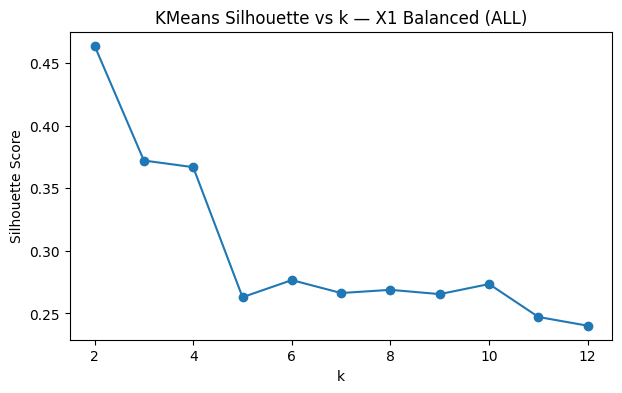

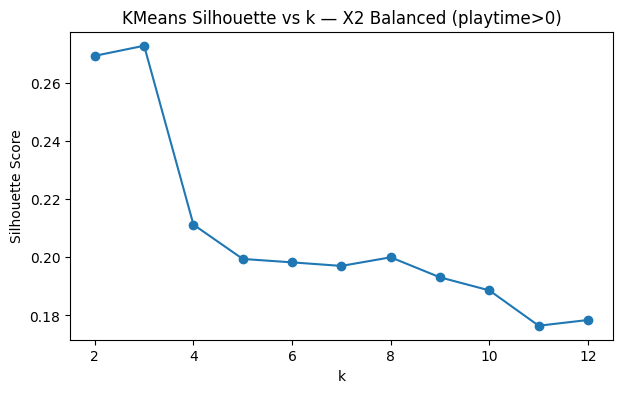

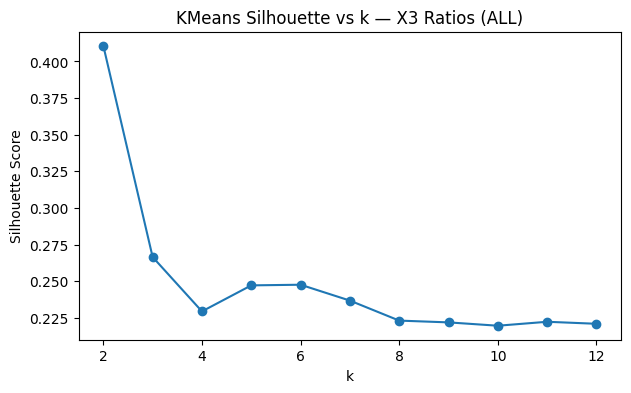

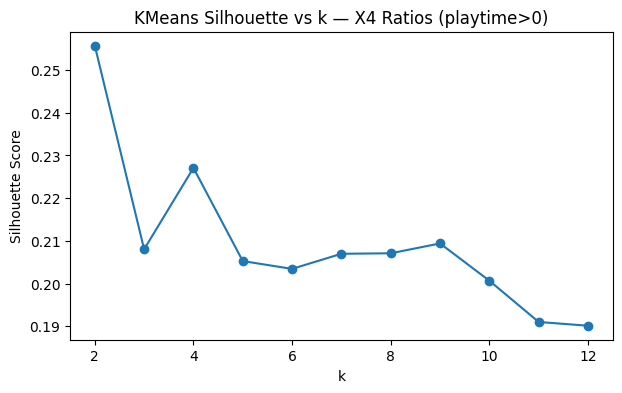

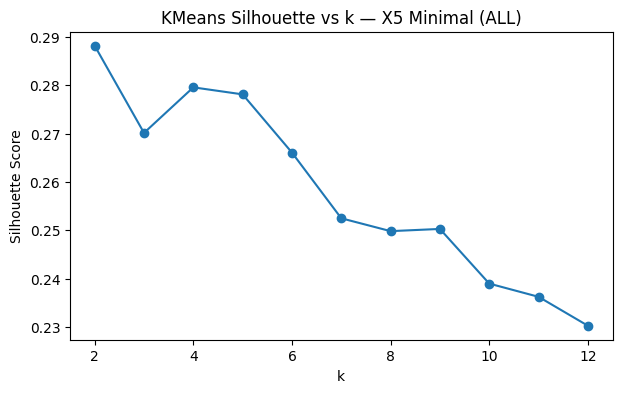

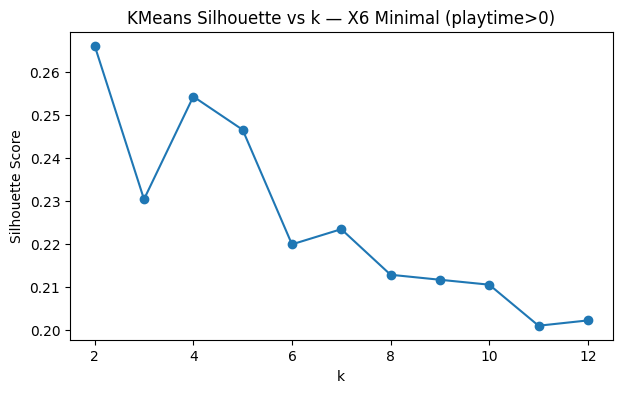

In [45]:
import matplotlib.pyplot as plt

for dataset in kmeans_results["Dataset"].unique():
    subset = kmeans_results[kmeans_results["Dataset"] == dataset]

    plt.figure(figsize=(7,4))
    plt.plot(subset["k"], subset["Silhouette"], marker="o")
    plt.title(f"KMeans Silhouette vs k — {dataset}")
    plt.xlabel("k")
    plt.ylabel("Silhouette Score")
    plt.show()

#GMM

In [46]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def eval_gmm_with_pca(X, name, n_components, k_range=range(2, 13), covariance_type="full"):
    # 1) Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2) PCA
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    rows = []

    for k in k_range:
        gmm = GaussianMixture(
            n_components=k,
            covariance_type=covariance_type,
            random_state=42,
            n_init=3
        )

        labels = gmm.fit_predict(X_pca)

        sil = silhouette_score(X_pca, labels)
        db = davies_bouldin_score(X_pca, labels)
        ch = calinski_harabasz_score(X_pca, labels)

        bic = gmm.bic(X_pca)
        aic = gmm.aic(X_pca)

        rows.append({
            "Dataset": name,
            "k": k,
            "Silhouette": sil,
            "Davies_Bouldin": db,
            "Calinski_Harabasz": ch,
            "BIC": bic,
            "AIC": aic,
            "covariance_type": covariance_type
        })

    return pd.DataFrame(rows)

In [47]:
k_range = range(2, 13)

gmm_results = pd.concat([
    eval_gmm_with_pca(X1, "X1 Balanced (ALL)", n_components=6, k_range=k_range),
    eval_gmm_with_pca(X2, "X2 Balanced (playtime>0)", n_components=6, k_range=k_range),
    eval_gmm_with_pca(X3, "X3 Ratios (ALL)", n_components=6, k_range=k_range),
    eval_gmm_with_pca(X4, "X4 Ratios (playtime>0)", n_components=5, k_range=k_range),
    eval_gmm_with_pca(X5, "X5 Minimal (ALL)", n_components=4, k_range=k_range),
    eval_gmm_with_pca(X6, "X6 Minimal (playtime>0)", n_components=4, k_range=k_range),
], ignore_index=True)

gmm_results.head()

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,BIC,AIC,covariance_type
0,X1 Balanced (ALL),2,0.423894,1.356451,17552.079588,445993.248371,445518.893230,full
1,X1 Balanced (ALL),3,0.304366,1.311561,12761.348229,212218.750187,211502.905156,full
2,X1 Balanced (ALL),4,0.187590,1.746345,9737.287437,54556.741824,53599.406903,full
3,X1 Balanced (ALL),5,0.304191,1.636147,8642.830904,136329.207194,135130.382382,full
4,X1 Balanced (ALL),6,0.190835,1.937771,7567.347910,4827.262519,3386.947817,full


In [48]:
best_gmm_sil = gmm_results.sort_values("Silhouette", ascending=False).groupby("Dataset").head(1)
best_gmm_sil[["Dataset", "k", "Silhouette", "Davies_Bouldin", "Calinski_Harabasz", "BIC", "AIC"]]

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,BIC,AIC
0,X1 Balanced (ALL),2,0.423894,1.356451,17552.079588,445993.248371,445518.893230
22,X3 Ratios (ALL),2,0.412315,1.255914,14761.970897,300180.461111,299706.105970
44,X5 Minimal (ALL),2,0.257356,1.695067,10613.735331,416098.742029,415848.627500
55,X6 Minimal (playtime>0),2,0.255786,1.452961,2619.747967,70668.852403,70471.013611
33,X4 Ratios (playtime>0),2,0.255621,1.582734,1286.135607,93190.965860,92911.262740
12,X2 Balanced (playtime>0),3,0.235238,1.493336,1793.862138,81521.232285,80955.004017


In [49]:
best_gmm_bic = gmm_results.sort_values("BIC", ascending=True).groupby("Dataset").head(1)
best_gmm_bic[["Dataset", "k", "Silhouette", "Davies_Bouldin", "Calinski_Harabasz", "BIC", "AIC"]]

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,BIC,AIC
32,X3 Ratios (ALL),12,0.078123,1.826989,5461.598882,-246135.033392,-249024.287434
10,X1 Balanced (ALL),12,0.079648,1.925859,6005.849077,-130189.568181,-133078.822222
65,X6 Minimal (playtime>0),12,0.067127,2.148943,942.721459,65734.563295,64513.420404
21,X2 Balanced (playtime>0),12,0.077177,2.133691,800.827594,76231.215323,73945.836170
43,X4 Ratios (playtime>0),12,0.037162,1.986301,706.114454,86477.409976,84765.081118
53,X5 Minimal (ALL),11,0.034773,1.891599,5164.950348,372756.192620,371341.751836


In [50]:
gmm_results[gmm_results["Dataset"] == "X1 Balanced (ALL)"].sort_values("k")

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,BIC,AIC,covariance_type
0,X1 Balanced (ALL),2,0.423894,1.356451,17552.079588,445993.248371,445518.893230,full
1,X1 Balanced (ALL),3,0.304366,1.311561,12761.348229,212218.750187,211502.905156,full
2,X1 Balanced (ALL),4,0.187590,1.746345,9737.287437,54556.741824,53599.406903,full
3,X1 Balanced (ALL),5,0.304191,1.636147,8642.830904,136329.207194,135130.382382,full
4,X1 Balanced (ALL),6,0.190835,1.937771,7567.347910,4827.262519,3386.947817,full
5,X1 Balanced (ALL),7,0.112831,2.396691,7167.964607,-70123.956499,-71805.761090,full
6,X1 Balanced (ALL),8,0.085926,2.041940,6711.668415,-98149.666326,-100072.960808,full
7,X1 Balanced (ALL),9,0.087935,1.895367,6946.105555,-102098.568343,-104263.352714,full
8,X1 Balanced (ALL),10,0.092671,1.732309,6765.820455,-124533.219787,-126939.494048,full
9,X1 Balanced (ALL),11,0.090124,2.281244,6127.020757,-129768.482049,-132416.246200,full


In [51]:
gmm_results[gmm_results["Dataset"] == "X2 Balanced (playtime>0)"].sort_values("k")

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,BIC,AIC,covariance_type
11,X2 Balanced (playtime>0),2,0.219281,1.808156,974.667299,85521.795554,85146.584052,full
12,X2 Balanced (playtime>0),3,0.235238,1.493336,1793.862138,81521.232285,80955.004017,full
13,X2 Balanced (playtime>0),4,0.151364,1.699983,1493.075317,79902.412440,79145.167407,full
14,X2 Balanced (playtime>0),5,0.140525,1.761945,1216.580836,78735.581366,77787.319568,full
15,X2 Balanced (playtime>0),6,0.088570,2.037197,1038.223956,77954.113387,76814.834824,full
16,X2 Balanced (playtime>0),7,0.085589,2.114168,979.260571,76843.787616,75513.492288,full
17,X2 Balanced (playtime>0),8,0.076596,1.989579,890.855618,76434.480599,74913.168506,full
18,X2 Balanced (playtime>0),9,0.090387,1.853801,946.608966,76300.938959,74588.610101,full
19,X2 Balanced (playtime>0),10,0.072037,2.226375,789.218330,76359.170607,74455.824984,full
20,X2 Balanced (playtime>0),11,0.062723,2.011710,814.645358,76241.418378,74147.055990,full


In [52]:
gmm_results[gmm_results["Dataset"] == "X3 Ratios (ALL)"].sort_values("k")

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,BIC,AIC,covariance_type
22,X3 Ratios (ALL),2,0.412315,1.255914,14761.970897,300180.461111,299706.105970,full
23,X3 Ratios (ALL),3,0.300097,1.375326,11364.152850,-102666.201786,-103382.046817,full
24,X3 Ratios (ALL),4,0.191328,2.018966,9080.608398,-132752.367866,-133709.702787,full
25,X3 Ratios (ALL),5,0.174924,1.756879,8847.474498,-145745.783862,-146944.608674,full
26,X3 Ratios (ALL),6,0.188471,2.042103,6473.823810,-213784.531256,-215224.845957,full
27,X3 Ratios (ALL),7,0.130287,1.987453,5706.854159,-216941.283813,-218623.088404,full
28,X3 Ratios (ALL),8,0.118277,1.952885,6376.767939,-232124.410577,-234047.705058,full
29,X3 Ratios (ALL),9,0.108821,2.197232,5833.250374,-236849.747434,-239014.531806,full
30,X3 Ratios (ALL),10,0.119744,2.183186,5232.211688,-237109.198436,-239515.472697,full
31,X3 Ratios (ALL),11,0.085600,2.165966,5304.372190,-241442.960083,-244090.724235,full


In [53]:
gmm_results[gmm_results["Dataset"] == "X4 Ratios (playtime>0)"].sort_values("k")

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,BIC,AIC,covariance_type
33,X4 Ratios (playtime>0),2,0.255621,1.582734,1286.135607,93190.965860,92911.262740,full
34,X4 Ratios (playtime>0),3,0.173695,1.771695,1378.521989,90165.054995,89742.089301,full
35,X4 Ratios (playtime>0),4,0.131085,2.044025,1020.652530,88315.437349,87749.209081,full
36,X4 Ratios (playtime>0),5,0.115860,1.826044,1080.436589,88030.029386,87320.538545,full
37,X4 Ratios (playtime>0),6,0.073484,2.301597,803.489888,86967.027834,86114.274418,full
38,X4 Ratios (playtime>0),7,0.067287,2.335346,735.323324,86734.017525,85738.001536,full
39,X4 Ratios (playtime>0),8,0.085733,1.988671,826.949593,86570.325508,85431.046945,full
40,X4 Ratios (playtime>0),9,0.088356,1.784878,829.617903,86624.131418,85341.590281,full
41,X4 Ratios (playtime>0),10,0.056212,2.417599,709.874595,86529.870162,85104.066452,full
42,X4 Ratios (playtime>0),11,0.044193,2.063872,688.491691,86502.761204,84933.694919,full


In [54]:
gmm_results[gmm_results["Dataset"] == "X5 Minimal (ALL)"].sort_values("k")

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,BIC,AIC,covariance_type
44,X5 Minimal (ALL),2,0.257356,1.695067,10613.735331,416098.742029,415848.627500,full
45,X5 Minimal (ALL),3,0.201518,1.438429,10777.756209,405762.406285,405382.922172,full
46,X5 Minimal (ALL),4,0.156157,1.512515,9134.686559,398684.271550,398175.417853,full
47,X5 Minimal (ALL),5,0.106108,1.807661,6949.033513,389777.594750,389139.371469,full
48,X5 Minimal (ALL),6,0.105930,1.620144,6676.286748,386725.933653,385958.340788,full
49,X5 Minimal (ALL),7,0.105788,1.525085,7017.253781,384349.456174,383452.493725,full
50,X5 Minimal (ALL),8,0.071854,1.831886,5858.233261,380362.317918,379335.985886,full
51,X5 Minimal (ALL),9,0.070728,1.710341,5799.955392,378923.560705,377767.859088,full
52,X5 Minimal (ALL),10,0.072399,1.564410,6000.158972,376650.878838,375365.807638,full
53,X5 Minimal (ALL),11,0.034773,1.891599,5164.950348,372756.192620,371341.751836,full


In [55]:
gmm_results[gmm_results["Dataset"] == "X6 Minimal (playtime>0)"].sort_values("k")

,Dataset,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,BIC,AIC,covariance_type
55,X6 Minimal (playtime>0),2,0.255786,1.452961,2619.747967,70668.852403,70471.013611,full
56,X6 Minimal (playtime>0),3,0.198852,1.706096,1570.922362,68197.806682,67897.637479,full
57,X6 Minimal (playtime>0),4,0.177638,1.567713,1602.435680,67628.321896,67225.822284,full
58,X6 Minimal (playtime>0),5,0.143303,1.859565,1519.951442,67224.007989,66719.177967,full
59,X6 Minimal (playtime>0),6,0.134070,1.523894,1407.698977,66931.307191,66324.146760,full
60,X6 Minimal (playtime>0),7,0.088257,2.014881,1206.401264,66487.296805,65777.805964,full
61,X6 Minimal (playtime>0),8,0.095262,1.647095,1246.454736,66375.385652,65563.564401,full
62,X6 Minimal (playtime>0),9,0.099448,1.666666,1165.787829,66265.476694,65351.325033,full
63,X6 Minimal (playtime>0),10,0.092532,1.797016,1136.263654,66325.441960,65308.959889,full
64,X6 Minimal (playtime>0),11,0.081002,1.680624,1051.428571,66238.840541,65120.028060,full


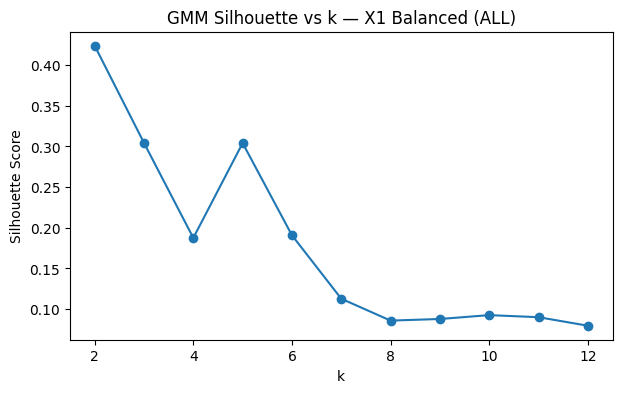

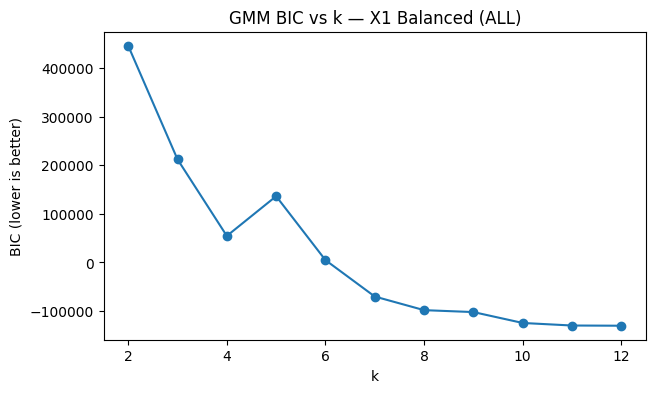

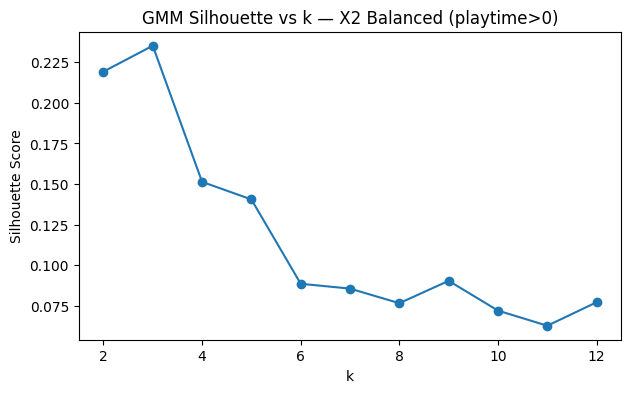

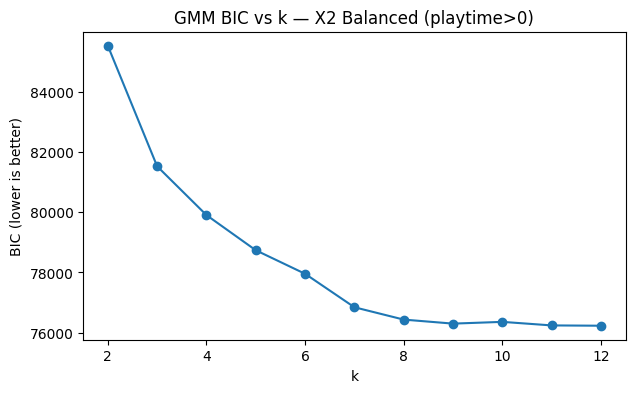

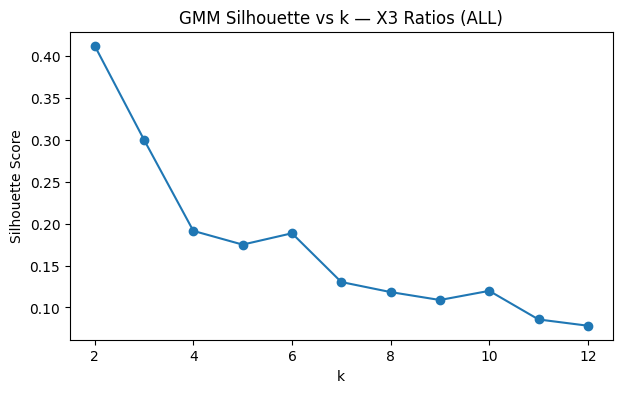

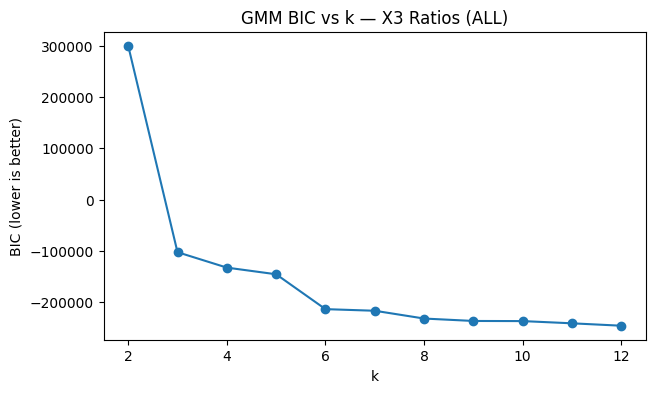

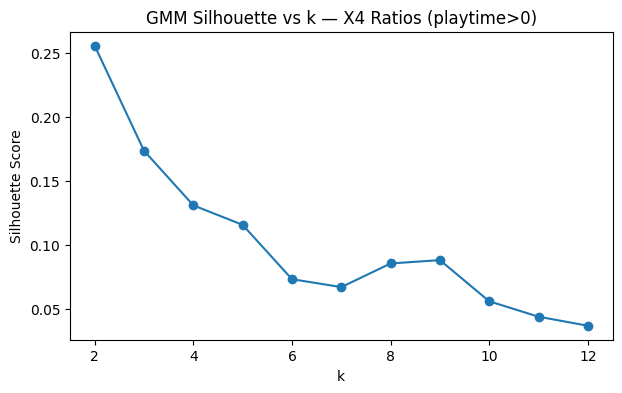

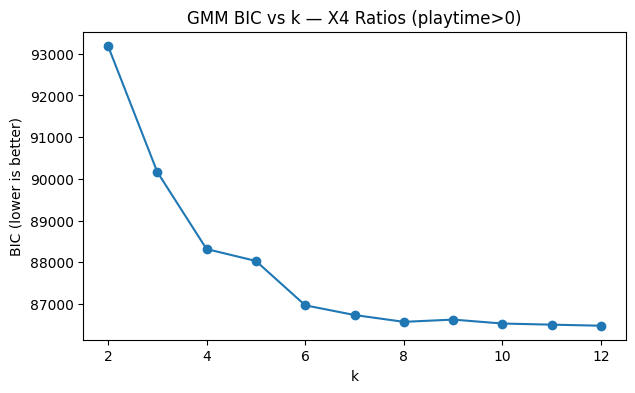

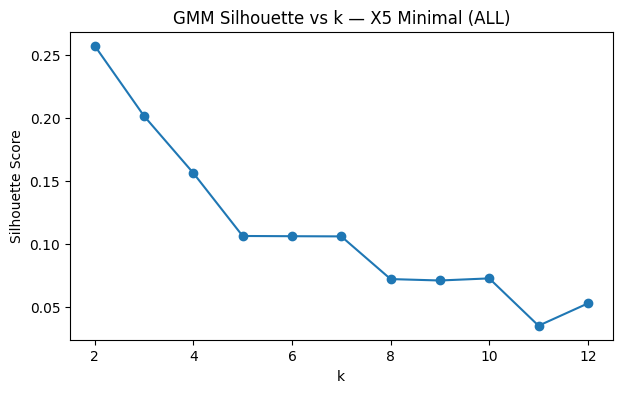

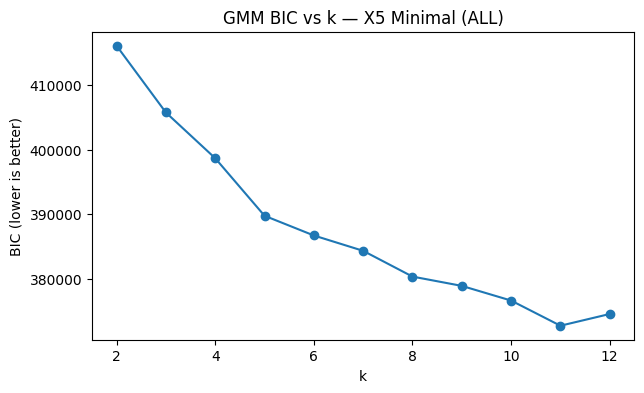

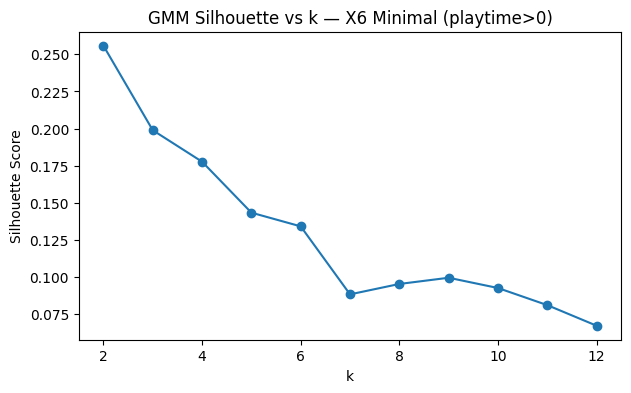

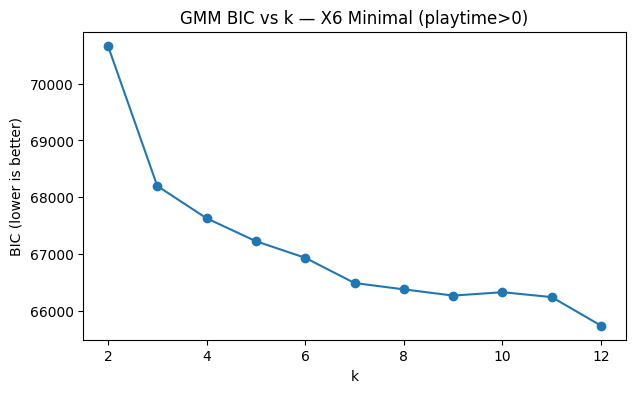

In [56]:
import matplotlib.pyplot as plt

for dataset in gmm_results["Dataset"].unique():
    subset = gmm_results[gmm_results["Dataset"] == dataset].sort_values("k")

    # Silhouette curve
    plt.figure(figsize=(7,4))
    plt.plot(subset["k"], subset["Silhouette"], marker="o")
    plt.title(f"GMM Silhouette vs k — {dataset}")
    plt.xlabel("k")
    plt.ylabel("Silhouette Score")
    plt.show()

    # BIC curve
    plt.figure(figsize=(7,4))
    plt.plot(subset["k"], subset["BIC"], marker="o")
    plt.title(f"GMM BIC vs k — {dataset}")
    plt.xlabel("k")
    plt.ylabel("BIC (lower is better)")
    plt.show()

#Agglomerative

In [57]:
from sklearn.cluster import AgglomerativeClustering

In [58]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

def eval_hierarchical_with_pca(X, name, n_components, k_range=range(2, 13), linkages=("ward","average","complete")):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    rows = []

    for linkage in linkages:
        for k in k_range:
            model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            labels = model.fit_predict(X_pca)

            sil = silhouette_score(X_pca, labels)
            db = davies_bouldin_score(X_pca, labels)
            ch = calinski_harabasz_score(X_pca, labels)

            rows.append({
                "Dataset": name,
                "linkage": linkage,
                "k": k,
                "Silhouette": sil,
                "Davies_Bouldin": db,
                "Calinski_Harabasz": ch
            })

    return pd.DataFrame(rows)

In [59]:
k_range = range(2, 13)

hier_results = pd.concat([
    eval_hierarchical_with_pca(X2, "X2 Balanced (playtime>0)", n_components=6, k_range=k_range),
    eval_hierarchical_with_pca(X4, "X4 Ratios (playtime>0)", n_components=5, k_range=k_range),
    eval_hierarchical_with_pca(X6, "X6 Minimal (playtime>0)", n_components=4, k_range=k_range),
], ignore_index=True)

hier_results.head()

,Dataset,linkage,k,Silhouette,Davies_Bouldin,Calinski_Harabasz
0,X2 Balanced (playtime>0),ward,2,0.240922,1.440869,1980.229728
1,X2 Balanced (playtime>0),ward,3,0.246275,1.459781,1798.562826
2,X2 Balanced (playtime>0),ward,4,0.143680,1.659899,1624.274212
3,X2 Balanced (playtime>0),ward,5,0.132160,1.690611,1430.194504
4,X2 Balanced (playtime>0),ward,6,0.140680,1.634141,1310.539536


In [60]:
best_hier_sil = (
    hier_results.sort_values("Silhouette", ascending=False)
                .groupby("Dataset")
                .head(1)
)

best_hier_sil[["Dataset", "linkage", "k", "Silhouette", "Davies_Bouldin", "Calinski_Harabasz"]]

,Dataset,linkage,k,Silhouette,Davies_Bouldin,Calinski_Harabasz
77,X6 Minimal (playtime>0),average,2,0.524196,0.629417,26.157444
11,X2 Balanced (playtime>0),average,2,0.412725,0.784482,12.933476
44,X4 Ratios (playtime>0),average,2,0.397383,0.735751,37.548702


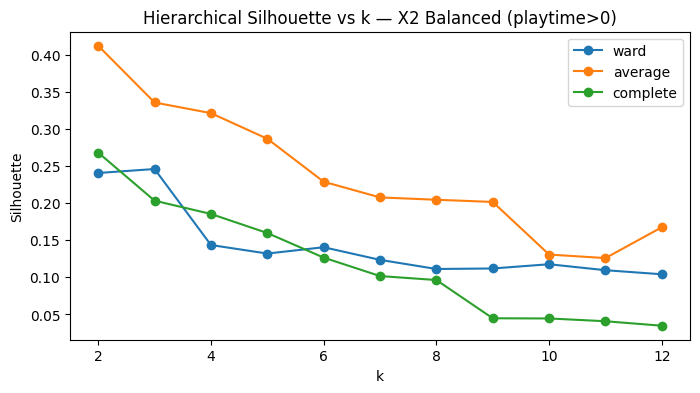

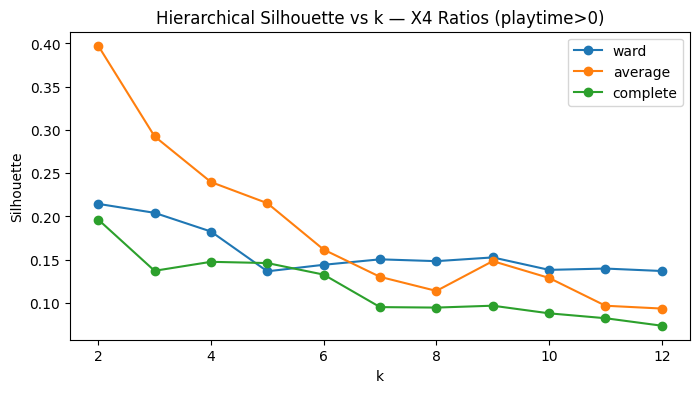

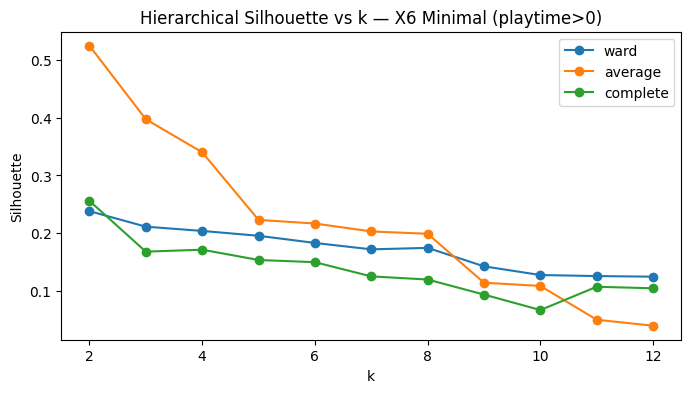

In [61]:
import matplotlib.pyplot as plt

for dataset in hier_results["Dataset"].unique():
    sub = hier_results[hier_results["Dataset"] == dataset]

    plt.figure(figsize=(8, 4))
    for linkage in sub["linkage"].unique():
        tmp = sub[sub["linkage"] == linkage].sort_values("k")
        plt.plot(tmp["k"], tmp["Silhouette"], marker="o", label=linkage)

    plt.title(f"Hierarchical Silhouette vs k — {dataset}")
    plt.xlabel("k")
    plt.ylabel("Silhouette")
    plt.legend()
    plt.show()

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

def quick_check_hier(X, name, n_components):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    model = AgglomerativeClustering(n_clusters=2, linkage="average")
    labels = model.fit_predict(X_pca)

    sil = silhouette_score(X_pca, labels)

    print(name)
    print("X shape:", X.shape)
    print("X_pca shape:", X_pca.shape)
    print("Silhouette (average linkage, k=2):", sil)
    print("-"*50)

quick_check_hier(X2, "X2 Balanced (playtime>0)", n_components=6)
quick_check_hier(X4, "X4 Ratios (playtime>0)", n_components=5)
quick_check_hier(X6, "X6 Minimal (playtime>0)", n_components=4)

X2 Balanced (playtime>0)
X shape: (6782, 9)
X_pca shape: (6782, 6)
Silhouette (average linkage, k=2): 0.41272516792377123
--------------------------------------------------
X4 Ratios (playtime>0)
X shape: (6782, 9)
X_pca shape: (6782, 5)
Silhouette (average linkage, k=2): 0.39738308560140423
--------------------------------------------------
X6 Minimal (playtime>0)
X shape: (6782, 4)
X_pca shape: (6782, 4)
Silhouette (average linkage, k=2): 0.5241959694455498
--------------------------------------------------


In [63]:
print("X2 shape:", X2.shape)
print("X4 shape:", X4.shape)
print("X6 shape:", X6.shape)

X2 shape: (6782, 9)
X4 shape: (6782, 9)
X6 shape: (6782, 4)


In [64]:
from collections import Counter

X_proc = StandardScaler().fit_transform(X6)
X_proc = PCA(n_components=4, random_state=42).fit_transform(X_proc)

labels = AgglomerativeClustering(n_clusters=2, linkage="average").fit_predict(X_proc)
Counter(labels)

Counter({np.int64(0): 6778, np.int64(1): 4})

In [65]:
def min_cluster_fraction(labels):
    counts = np.array(list(Counter(labels).values()))
    return counts.min() / counts.sum()

In [66]:
def eval_hierarchical_checked(X, name, n_components, k_range=range(2, 13),
                              linkages=("ward","average","complete"),
                              min_frac=0.01, random_state=42):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components, random_state=random_state)
    X_pca = pca.fit_transform(X_scaled)

    rows = []
    for linkage in linkages:
        for k in k_range:

            model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            labels = model.fit_predict(X_pca)

            sil = silhouette_score(X_pca, labels)
            db = davies_bouldin_score(X_pca, labels)
            ch = calinski_harabasz_score(X_pca, labels)

            frac = min_cluster_fraction(labels)
            counts = Counter(labels)

            rows.append({
                "Dataset": name,
                "linkage": linkage,
                "k": k,
                "Silhouette": sil,
                "Davies_Bouldin": db,
                "Calinski_Harabasz": ch,
                "min_cluster_frac": frac,
                "min_cluster_size": min(counts.values()),
                "max_cluster_size": max(counts.values()),
                "valid": frac >= min_frac
            })

    return pd.DataFrame(rows)

In [67]:
hier_results = pd.concat([
    eval_hierarchical_checked(X2, "X2 Balanced (playtime>0)", n_components=6),
    eval_hierarchical_checked(X4, "X4 Ratios (playtime>0)", n_components=5),
    eval_hierarchical_checked(X6, "X6 Minimal (playtime>0)", n_components=4),
], ignore_index=True)

hier_results.head()

,Dataset,linkage,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster_frac,min_cluster_size,max_cluster_size,valid
0,X2 Balanced (playtime>0),ward,2,0.240922,1.440869,1980.229728,0.234592,1591,5191,True
1,X2 Balanced (playtime>0),ward,3,0.246275,1.459781,1798.562826,0.143468,973,4218,True
2,X2 Balanced (playtime>0),ward,4,0.143680,1.659899,1624.274212,0.143468,973,2542,True
3,X2 Balanced (playtime>0),ward,5,0.132160,1.690611,1430.194504,0.104247,707,2542,True
4,X2 Balanced (playtime>0),ward,6,0.140680,1.634141,1310.539536,0.048068,326,2542,True


In [68]:
hier_results[hier_results["Dataset"] == "X2 Balanced (playtime>0)"] \
    .sort_values(["linkage", "k"]) \
    .reset_index(drop=True)

,Dataset,linkage,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster_frac,min_cluster_size,max_cluster_size,valid
0,X2 Balanced (playtime>0),average,2,0.412725,0.784482,12.933476,0.000442,3,6779,False
1,X2 Balanced (playtime>0),average,3,0.336089,1.021658,78.009559,0.000442,3,6726,False
2,X2 Balanced (playtime>0),average,4,0.321709,0.953900,56.253125,0.000442,3,6726,False
3,X2 Balanced (playtime>0),average,5,0.287132,0.850169,42.930531,0.000147,1,6726,False
4,X2 Balanced (playtime>0),average,6,0.229116,1.034555,497.344038,0.000147,1,5229,False
5,X2 Balanced (playtime>0),average,7,0.207929,1.043880,421.396655,0.000147,1,5229,False
6,X2 Balanced (playtime>0),average,8,0.204781,0.985240,364.046540,0.000147,1,5229,False
7,X2 Balanced (playtime>0),average,9,0.201828,0.921400,319.083869,0.000147,1,5229,False
8,X2 Balanced (playtime>0),average,10,0.130800,0.953393,288.007650,0.000147,1,5213,False
9,X2 Balanced (playtime>0),average,11,0.126033,0.884932,259.423922,0.000147,1,5213,False


In [69]:
hier_results[hier_results["Dataset"] == "X4 Ratios (playtime>0)"] \
    .sort_values(["linkage", "k"]) \
    .reset_index(drop=True)

,Dataset,linkage,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster_frac,min_cluster_size,max_cluster_size,valid
0,X4 Ratios (playtime>0),average,2,0.397383,0.735751,37.548702,0.001327,9,6773,False
1,X4 Ratios (playtime>0),average,3,0.292597,0.938952,32.564867,0.001180,8,6765,False
2,X4 Ratios (playtime>0),average,4,0.239805,1.109947,142.812005,0.001180,8,6623,False
3,X4 Ratios (playtime>0),average,5,0.215370,1.000469,108.210969,0.000295,2,6623,False
4,X4 Ratios (playtime>0),average,6,0.161711,1.107097,128.319050,0.000295,2,6519,False
5,X4 Ratios (playtime>0),average,7,0.130190,1.061090,120.085849,0.000295,2,6519,False
6,X4 Ratios (playtime>0),average,8,0.113934,0.974317,103.476520,0.000295,2,6519,False
7,X4 Ratios (playtime>0),average,9,0.148388,1.029027,282.459637,0.000295,2,5587,False
8,X4 Ratios (playtime>0),average,10,0.128918,1.019614,257.955466,0.000295,2,5587,False
9,X4 Ratios (playtime>0),average,11,0.096805,1.049931,292.905513,0.000295,2,5297,False


In [70]:
hier_results[hier_results["Dataset"] == "X6 Minimal (playtime>0)"] \
    .sort_values(["linkage", "k"]) \
    .reset_index(drop=True)

,Dataset,linkage,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster_frac,min_cluster_size,max_cluster_size,valid
0,X6 Minimal (playtime>0),average,2,0.524196,0.629417,26.157444,0.000590,4,6778,False
1,X6 Minimal (playtime>0),average,3,0.397110,0.890225,494.850928,0.000590,4,6490,False
2,X6 Minimal (playtime>0),average,4,0.340088,0.955179,367.107482,0.000590,4,6490,False
3,X6 Minimal (playtime>0),average,5,0.223247,0.878077,276.080792,0.000147,1,6489,False
4,X6 Minimal (playtime>0),average,6,0.216977,0.858777,222.053889,0.000147,1,6489,False
5,X6 Minimal (playtime>0),average,7,0.203302,0.944622,412.650451,0.000147,1,5905,False
6,X6 Minimal (playtime>0),average,8,0.199265,0.992837,355.993461,0.000147,1,5905,False
7,X6 Minimal (playtime>0),average,9,0.114697,0.948740,311.887486,0.000147,1,5904,False
8,X6 Minimal (playtime>0),average,10,0.109138,0.884095,277.907517,0.000147,1,5904,False
9,X6 Minimal (playtime>0),average,11,0.050722,0.918115,315.195707,0.000147,1,5642,False


In [71]:
best_hier_valid = (
    hier_results[hier_results["valid"] == True]
    .sort_values(["Dataset", "Silhouette"], ascending=[True, False])
    .groupby("Dataset")
    .head(1)
)

best_hier_valid[["Dataset","linkage","k","Silhouette","Davies_Bouldin","Calinski_Harabasz",
                 "min_cluster_size","max_cluster_size","min_cluster_frac"]]

,Dataset,linkage,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster_size,max_cluster_size,min_cluster_frac
22,X2 Balanced (playtime>0),complete,2,0.268460,1.563074,1885.317233,1506,5276,0.222058
33,X4 Ratios (playtime>0),ward,2,0.214573,1.642507,2204.335535,3271,3511,0.482306
88,X6 Minimal (playtime>0),complete,2,0.256124,1.403777,1833.453955,1308,5474,0.192863


In [72]:
hier_results[hier_results["valid"] == False].sort_values("Silhouette", ascending=False).head(10)

,Dataset,linkage,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster_frac,min_cluster_size,max_cluster_size,valid
77,X6 Minimal (playtime>0),average,2,0.524196,0.629417,26.157444,0.000590,4,6778,False
11,X2 Balanced (playtime>0),average,2,0.412725,0.784482,12.933476,0.000442,3,6779,False
44,X4 Ratios (playtime>0),average,2,0.397383,0.735751,37.548702,0.001327,9,6773,False
78,X6 Minimal (playtime>0),average,3,0.397110,0.890225,494.850928,0.000590,4,6490,False
79,X6 Minimal (playtime>0),average,4,0.340088,0.955179,367.107482,0.000590,4,6490,False
12,X2 Balanced (playtime>0),average,3,0.336089,1.021658,78.009559,0.000442,3,6726,False
13,X2 Balanced (playtime>0),average,4,0.321709,0.953900,56.253125,0.000442,3,6726,False
45,X4 Ratios (playtime>0),average,3,0.292597,0.938952,32.564867,0.001180,8,6765,False
14,X2 Balanced (playtime>0),average,5,0.287132,0.850169,42.930531,0.000147,1,6726,False
46,X4 Ratios (playtime>0),average,4,0.239805,1.109947,142.812005,0.001180,8,6623,False


#Model Comparison

In [73]:
for r in results_pca:
    print(r["name"], r["X_pca"].shape)

X1 Balanced (ALL) (41136, 9)
X2 Balanced (playtime>0) (6782, 9)
X3 Ratios (ALL) (41136, 9)
X4 Ratios (playtime>0) (6782, 9)
X5 Minimal (ALL) (41136, 4)
X6 Minimal (playtime>0) (6782, 4)


In [74]:
import numpy as np

def get_pca90_from_results(results_pca, dataset_name):
    r = [x for x in results_pca if x["name"] == dataset_name][0]
    pcs = r["pcs_90"]
    X_pca90 = r["X_pca"][:, :pcs]
    return X_pca90, pcs

X2_pca90, X2_pcs = get_pca90_from_results(results_pca, "X2 Balanced (playtime>0)")
X4_pca90, X4_pcs = get_pca90_from_results(results_pca, "X4 Ratios (playtime>0)")
X6_pca90, X6_pcs = get_pca90_from_results(results_pca, "X6 Minimal (playtime>0)")

print("X2 PCA90:", X2_pca90.shape, "| PCs:", X2_pcs)
print("X4 PCA90:", X4_pca90.shape, "| PCs:", X4_pcs)
print("X6 PCA90:", X6_pca90.shape, "| PCs:", X6_pcs)

X2 PCA90: (6782, 6) | PCs: 6
X4 PCA90: (6782, 5) | PCs: 5
X6 PCA90: (6782, 4) | PCs: 4


In [75]:
pca90_map = {}

for res in results_pca:
    pcs_90 = res["pcs_90"]
    X_pca90 = res["X_pca"][:, :pcs_90]
    pca90_map[res["name"]] = {
        "X_pca90": X_pca90,
        "pcs_90": pcs_90,
        "rows": res["rows"],
        "features": res["features"],
    }

print("PCA90 datasets available:")
for k, v in pca90_map.items():
    print(f"- {k}: {v['X_pca90'].shape} | pcs_90={v['pcs_90']}")

PCA90 datasets available:
- X1 Balanced (ALL): (41136, 6) | pcs_90=6
- X2 Balanced (playtime>0): (6782, 6) | pcs_90=6
- X3 Ratios (ALL): (41136, 6) | pcs_90=6
- X4 Ratios (playtime>0): (6782, 5) | pcs_90=5
- X5 Minimal (ALL): (41136, 4) | pcs_90=4
- X6 Minimal (playtime>0): (6782, 4) | pcs_90=4


In [76]:
def get_pca90(results_pca, dataset_name):
    r = [x for x in results_pca if x["name"] == dataset_name][0]
    pcs = r["pcs_90"]
    return r["X_pca"][:, :pcs], pcs

X1_pca90, X1_pcs = get_pca90(results_pca, "X1 Balanced (ALL)")
X2_pca90, X2_pcs = get_pca90(results_pca, "X2 Balanced (playtime>0)")
X3_pca90, X3_pcs = get_pca90(results_pca, "X3 Ratios (ALL)")
X4_pca90, X4_pcs = get_pca90(results_pca, "X4 Ratios (playtime>0)")
X5_pca90, X5_pcs = get_pca90(results_pca, "X5 Minimal (ALL)")
X6_pca90, X6_pcs = get_pca90(results_pca, "X6 Minimal (playtime>0)")

print("X2:", X2_pca90.shape, "pcs:", X2_pcs)
print("X4:", X4_pca90.shape, "pcs:", X4_pcs)
print("X6:", X6_pca90.shape, "pcs:", X6_pcs)

X2: (6782, 6) pcs: 6
X4: (6782, 5) pcs: 5
X6: (6782, 4) pcs: 4


In [77]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def cluster_size_stats(labels):
    vc = pd.Series(labels).value_counts()
    return int(vc.min()), int(vc.max()), float(vc.min()/vc.sum())

def eval_kmeans(X, dataset, ks=range(2,7)):
    out=[]
    for k in ks:
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = model.fit_predict(X)
        mn, mx, frac = cluster_size_stats(labels)
        out.append([dataset, "KMeans", "-", k,
                    silhouette_score(X, labels),
                    davies_bouldin_score(X, labels),
                    calinski_harabasz_score(X, labels),
                    mn, mx, frac])
    return out

def eval_gmm(X, dataset, ks=range(2,7)):
    out=[]
    for k in ks:
        model = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
        model.fit(X)
        labels = model.predict(X)
        mn, mx, frac = cluster_size_stats(labels)
        out.append([dataset, "GMM", "full", k,
                    silhouette_score(X, labels),
                    davies_bouldin_score(X, labels),
                    calinski_harabasz_score(X, labels),
                    mn, mx, frac,
                    model.bic(X), model.aic(X)])
    return out

def eval_hier(X, dataset, ks=range(2,7), linkages=("ward","complete")):
    out=[]
    for linkage in linkages:
        # ward only works with euclidean; fine for PCA space
        for k in ks:
            model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            labels = model.fit_predict(X)
            mn, mx, frac = cluster_size_stats(labels)
            out.append([dataset, "Hierarchical", linkage, k,
                        silhouette_score(X, labels),
                        davies_bouldin_score(X, labels),
                        calinski_harabasz_score(X, labels),
                        mn, mx, frac])
    return out

rows=[]

# Playtime>0 only
datasets = {
    "X2 Balanced (playtime>0)": X2_pca90,
    "X4 Ratios (playtime>0)": X4_pca90,
    "X6 Minimal (playtime>0)": X6_pca90
}

# KMeans + Hierarchical
for name, X in datasets.items():
    rows += eval_kmeans(X, name)
    rows += eval_hier(X, name)

df_basic = pd.DataFrame(rows, columns=[
    "Dataset","Algorithm","Linkage/Cov","k",
    "Silhouette","Davies_Bouldin","Calinski_Harabasz",
    "min_cluster","max_cluster","min_cluster_frac"
])

# GMM separately (has BIC/AIC)
gmm_rows=[]
for name, X in datasets.items():
    gmm_rows += eval_gmm(X, name)

df_gmm = pd.DataFrame(gmm_rows, columns=[
    "Dataset","Algorithm","Linkage/Cov","k",
    "Silhouette","Davies_Bouldin","Calinski_Harabasz",
    "min_cluster","max_cluster","min_cluster_frac",
    "BIC","AIC"
])

display(df_basic.sort_values(["Dataset","Algorithm","Linkage/Cov","k"]).reset_index(drop=True))
display(df_gmm.sort_values(["Dataset","k"]).reset_index(drop=True))

,Dataset,Algorithm,Linkage/Cov,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster,max_cluster,min_cluster_frac
0,X2 Balanced (playtime>0),Hierarchical,complete,2,0.268460,1.563074,1885.317233,1506,5276,0.222058
1,X2 Balanced (playtime>0),Hierarchical,complete,3,0.203537,2.141044,1112.476729,527,5276,0.077706
2,X2 Balanced (playtime>0),Hierarchical,complete,4,0.185608,1.761847,826.252518,101,5276,0.014892
3,X2 Balanced (playtime>0),Hierarchical,complete,5,0.159892,1.863097,722.536041,101,5276,0.014892
4,X2 Balanced (playtime>0),Hierarchical,complete,6,0.126682,1.857533,759.744763,101,4671,0.014892
5,X2 Balanced (playtime>0),Hierarchical,ward,2,0.240922,1.440869,1980.229728,1591,5191,0.234592
6,X2 Balanced (playtime>0),Hierarchical,ward,3,0.246275,1.459781,1798.562826,973,4218,0.143468
7,X2 Balanced (playtime>0),Hierarchical,ward,4,0.143680,1.659899,1624.274212,973,2542,0.143468
8,X2 Balanced (playtime>0),Hierarchical,ward,5,0.132160,1.690611,1430.194504,707,2542,0.104247
9,X2 Balanced (playtime>0),Hierarchical,ward,6,0.140680,1.634141,1310.539536,326,2542,0.048068


,Dataset,Algorithm,Linkage/Cov,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster,max_cluster,min_cluster_frac,BIC,AIC
0,X2 Balanced (playtime>0),GMM,full,2,0.219281,1.808156,974.667299,1125,5657,0.165880,85521.795579,85146.584077
1,X2 Balanced (playtime>0),GMM,full,3,0.235238,1.493336,1793.862138,1126,3497,0.166028,81521.232285,80955.004017
2,X2 Balanced (playtime>0),GMM,full,4,0.153188,1.692239,1497.020233,1121,2216,0.165290,79920.988631,79163.743599
3,X2 Balanced (playtime>0),GMM,full,5,0.140525,1.761945,1216.580836,698,1711,0.102919,78735.581366,77787.319568
4,X2 Balanced (playtime>0),GMM,full,6,0.112211,1.878166,963.968863,533,1834,0.078590,78395.179709,77255.901146
5,X4 Ratios (playtime>0),GMM,full,2,0.255621,1.582734,1286.135607,1103,5679,0.162636,93190.981253,92911.278133
6,X4 Ratios (playtime>0),GMM,full,3,0.173756,1.771902,1377.325635,1103,3308,0.162636,90167.444350,89744.478656
7,X4 Ratios (playtime>0),GMM,full,4,0.131113,2.043974,1020.654795,1096,3007,0.161604,88316.083024,87749.854756
8,X4 Ratios (playtime>0),GMM,full,5,0.115882,1.826086,1080.077306,818,2148,0.120613,88031.038010,87321.547168
9,X4 Ratios (playtime>0),GMM,full,6,0.073484,2.301597,803.489888,596,1703,0.087880,86967.027834,86114.274418


In [78]:
best_basic = (df_basic
              .sort_values(["Dataset","Algorithm","Silhouette","Davies_Bouldin"],
                           ascending=[True, True, False, True])
              .groupby(["Dataset","Algorithm"], as_index=False)
              .head(1)
              .reset_index(drop=True))

print("BEST KMeans + Hierarchical per dataset:")
display(best_basic)

best_gmm_bic = (df_gmm
                .sort_values(["Dataset","BIC"], ascending=[True, True])
                .groupby(["Dataset"], as_index=False)
                .head(1)
                .reset_index(drop=True))

best_gmm_sil = (df_gmm
                .sort_values(["Dataset","Silhouette","Davies_Bouldin"],
                             ascending=[True, False, True])
                .groupby(["Dataset"], as_index=False)
                .head(1)
                .reset_index(drop=True))

print("BEST GMM per dataset (by BIC):")
display(best_gmm_bic)

print("BEST GMM per dataset (by Silhouette):")
display(best_gmm_sil)

BEST KMeans + Hierarchical per dataset:


,Dataset,Algorithm,Linkage/Cov,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster,max_cluster,min_cluster_frac
0,X2 Balanced (playtime>0),Hierarchical,complete,2,0.268460,1.563074,1885.317233,1506,5276,0.222058
1,X2 Balanced (playtime>0),KMeans,-,3,0.272796,1.349259,2176.276865,879,3770,0.129608
2,X4 Ratios (playtime>0),Hierarchical,ward,2,0.214573,1.642507,2204.335535,3271,3511,0.482306
3,X4 Ratios (playtime>0),KMeans,-,2,0.255700,1.484854,2676.668538,2826,3956,0.416691
4,X6 Minimal (playtime>0),Hierarchical,complete,2,0.256124,1.403777,1833.453955,1308,5474,0.192863
5,X6 Minimal (playtime>0),KMeans,-,2,0.266006,1.418458,2793.573150,3233,3549,0.476703


BEST GMM per dataset (by BIC):


,Dataset,Algorithm,Linkage/Cov,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster,max_cluster,min_cluster_frac,BIC,AIC
0,X2 Balanced (playtime>0),GMM,full,6,0.112211,1.878166,963.968863,533,1834,0.078590,78395.179709,77255.901146
1,X4 Ratios (playtime>0),GMM,full,6,0.073484,2.301597,803.489888,596,1703,0.087880,86967.027834,86114.274418
2,X6 Minimal (playtime>0),GMM,full,6,0.134070,1.523894,1407.698977,569,1507,0.083899,66931.307191,66324.146760


BEST GMM per dataset (by Silhouette):


,Dataset,Algorithm,Linkage/Cov,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster,max_cluster,min_cluster_frac,BIC,AIC
0,X2 Balanced (playtime>0),GMM,full,3,0.235238,1.493336,1793.862138,1126,3497,0.166028,81521.232285,80955.004017
1,X4 Ratios (playtime>0),GMM,full,2,0.255621,1.582734,1286.135607,1103,5679,0.162636,93190.981253,92911.278133
2,X6 Minimal (playtime>0),GMM,full,2,0.255786,1.452961,2619.747967,3084,3698,0.454733,70668.852403,70471.013611


In [79]:
datasets_all6 = {
    "X1 Balanced (ALL)": X1_pca90,
    "X2 Balanced (playtime>0)": X2_pca90,
    "X3 Ratios (ALL)": X3_pca90,
    "X4 Ratios (playtime>0)": X4_pca90,
    "X5 Minimal (ALL)": X5_pca90,
    "X6 Minimal (playtime>0)": X6_pca90
}

In [80]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


def cluster_size_stats(labels):
    vc = pd.Series(labels).value_counts()
    return int(vc.min()), int(vc.max()), float(vc.min() / vc.sum())

def eval_kmeans(X, dataset, ks):
    out = []
    for k in ks:
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = model.fit_predict(X)
        mn, mx, frac = cluster_size_stats(labels)
        out.append([dataset, "KMeans", "-", k,
                    silhouette_score(X, labels),
                    davies_bouldin_score(X, labels),
                    calinski_harabasz_score(X, labels),
                    mn, mx, frac])
    return out

def eval_gmm(X, dataset, ks):
    out = []
    for k in ks:
        model = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
        model.fit(X)
        labels = model.predict(X)
        mn, mx, frac = cluster_size_stats(labels)
        out.append([dataset, "GMM", "full", k,
                    silhouette_score(X, labels),
                    davies_bouldin_score(X, labels),
                    calinski_harabasz_score(X, labels),
                    mn, mx, frac,
                    model.bic(X), model.aic(X)])
    return out

def eval_hier(X, dataset, ks, linkages):
    out = []
    for linkage in linkages:
        for k in ks:

            model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            labels = model.fit_predict(X)
            mn, mx, frac = cluster_size_stats(labels)
            out.append([dataset, "Hierarchical", linkage, k,
                        silhouette_score(X, labels),
                        davies_bouldin_score(X, labels),
                        calinski_harabasz_score(X, labels),
                        mn, mx, frac])
    return out


assert "datasets_all6" in globals(), "datasets_all6 not found. Make sure you created it earlier."


def pick_by_prefix(dct, prefix):
    hits = [k for k in dct.keys() if str(k).strip().upper().startswith(prefix)]
    if not hits:

        hits = [k for k in dct.keys() if prefix in str(k).upper()]
    if not hits:
        raise KeyError(f"Couldn't find a dataset key matching {prefix}. Available keys: {list(dct.keys())[:10]} ...")

    return hits[0]

k1 = pick_by_prefix(datasets_all6, "X1")
k2 = pick_by_prefix(datasets_all6, "X2")
k3 = pick_by_prefix(datasets_all6, "X3")
k4 = pick_by_prefix(datasets_all6, "X4")
k5 = pick_by_prefix(datasets_all6, "X5")
k6 = pick_by_prefix(datasets_all6, "X6")

X1 = datasets_all6[k1]
X2 = datasets_all6[k2]
X3 = datasets_all6[k3]
X4 = datasets_all6[k4]
X5 = datasets_all6[k5]
X6 = datasets_all6[k6]

print("Using keys:")
print("X1:", k1, "| shape:", getattr(X1, "shape", None))
print("X2:", k2, "| shape:", getattr(X2, "shape", None))
print("X3:", k3, "| shape:", getattr(X3, "shape", None))
print("X4:", k4, "| shape:", getattr(X4, "shape", None))
print("X5:", k5, "| shape:", getattr(X5, "shape", None))
print("X6:", k6, "| shape:", getattr(X6, "shape", None))


KS = range(2, 13)
H_LINKS = ("ward", "complete")

basic_rows = []
gmm_rows   = []
hier_rows  = []


for name, X in [(k1, X1), (k3, X3), (k5, X5)]:
    basic_rows += eval_kmeans(X, name, KS)
    gmm_rows   += eval_gmm(X, name, KS)


for name, X in [(k2, X2), (k4, X4), (k6, X6)]:
    hier_rows += eval_hier(X, name, KS, H_LINKS)


df_kmeans = pd.DataFrame(basic_rows, columns=[
    "Dataset","Algorithm","Linkage/Cov","k",
    "Silhouette","Davies_Bouldin","Calinski_Harabasz",
    "min_cluster","max_cluster","min_cluster_frac"
])

df_gmm = pd.DataFrame(gmm_rows, columns=[
    "Dataset","Algorithm","Linkage/Cov","k",
    "Silhouette","Davies_Bouldin","Calinski_Harabasz",
    "min_cluster","max_cluster","min_cluster_frac",
    "BIC","AIC"
])

df_hier = pd.DataFrame(hier_rows, columns=[
    "Dataset","Algorithm","Linkage/Cov","k",
    "Silhouette","Davies_Bouldin","Calinski_Harabasz",
    "min_cluster","max_cluster","min_cluster_frac"
])

print("\nDONE ✅")
print("KMeans rows:", len(df_kmeans), "| GMM rows:", len(df_gmm), "| Hier rows:", len(df_hier))

display(df_kmeans.sort_values(["Dataset","k"]).reset_index(drop=True))
display(df_gmm.sort_values(["Dataset","k"]).reset_index(drop=True))
display(df_hier.sort_values(["Dataset","Linkage/Cov","k"]).reset_index(drop=True))


Using keys:
X1: X1 Balanced (ALL) | shape: (41136, 6)
X2: X2 Balanced (playtime>0) | shape: (6782, 6)
X3: X3 Ratios (ALL) | shape: (41136, 6)
X4: X4 Ratios (playtime>0) | shape: (6782, 5)
X5: X5 Minimal (ALL) | shape: (41136, 4)
X6: X6 Minimal (playtime>0) | shape: (6782, 4)

DONE ✅
KMeans rows: 33 | GMM rows: 33 | Hier rows: 66


,Dataset,Algorithm,Linkage/Cov,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster,max_cluster,min_cluster_frac
0,X1 Balanced (ALL),KMeans,-,2,0.463851,1.187998,19802.484269,7881,33255,0.191584
1,X1 Balanced (ALL),KMeans,-,3,0.372145,1.159907,14261.884906,3741,30002,0.090942
2,X1 Balanced (ALL),KMeans,-,4,0.366827,1.263050,13049.777108,3488,27212,0.084792
3,X1 Balanced (ALL),KMeans,-,5,0.262966,1.378727,13126.026418,2988,17804,0.072637
4,X1 Balanced (ALL),KMeans,-,6,0.276608,1.211788,12963.271855,2217,17034,0.053894
5,X1 Balanced (ALL),KMeans,-,7,0.266298,1.191277,12562.048555,2249,14293,0.054672
6,X1 Balanced (ALL),KMeans,-,8,0.268835,1.195042,11895.737972,1654,12756,0.040208
7,X1 Balanced (ALL),KMeans,-,9,0.265418,1.097739,11644.788309,32,12098,0.000778
8,X1 Balanced (ALL),KMeans,-,10,0.273456,1.081020,11348.643222,32,12132,0.000778
9,X1 Balanced (ALL),KMeans,-,11,0.247161,1.085829,11034.650596,32,9921,0.000778


,Dataset,Algorithm,Linkage/Cov,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster,max_cluster,min_cluster_frac,BIC,AIC
0,X1 Balanced (ALL),GMM,full,2,0.423894,1.356451,17552.079588,9617,31519,0.233785,445993.248371,445518.893230
1,X1 Balanced (ALL),GMM,full,3,0.434854,1.527602,12665.412161,3279,31727,0.079711,428825.012872,428109.167841
2,X1 Balanced (ALL),GMM,full,4,0.286658,1.708489,9189.312726,1122,26908,0.027275,156719.544624,155762.209703
3,X1 Balanced (ALL),GMM,full,5,0.304191,1.636147,8642.830904,1120,27191,0.027227,136329.207194,135130.382382
4,X1 Balanced (ALL),GMM,full,6,0.190725,1.935380,7572.598374,1120,20258,0.027227,4831.297953,3390.983252
5,X1 Balanced (ALL),GMM,full,7,0.112831,2.396691,7167.964607,1120,16123,0.027227,-70123.956499,-71805.761090
6,X1 Balanced (ALL),GMM,full,8,0.085926,2.041940,6711.668415,1120,16019,0.027227,-98149.666326,-100072.960808
7,X1 Balanced (ALL),GMM,full,9,0.076058,2.002551,6008.291033,406,16019,0.009870,-98883.322725,-101048.107097
8,X1 Balanced (ALL),GMM,full,10,0.076576,2.034800,5691.421336,398,15978,0.009675,-123551.581522,-125957.855784
9,X1 Balanced (ALL),GMM,full,11,0.076730,1.919738,5635.896122,32,15977,0.000778,-125613.074623,-128260.838774


,Dataset,Algorithm,Linkage/Cov,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster,max_cluster,min_cluster_frac
0,X2 Balanced (playtime>0),Hierarchical,complete,2,0.268460,1.563074,1885.317233,1506,5276,0.222058
1,X2 Balanced (playtime>0),Hierarchical,complete,3,0.203537,2.141044,1112.476729,527,5276,0.077706
2,X2 Balanced (playtime>0),Hierarchical,complete,4,0.185608,1.761847,826.252518,101,5276,0.014892
3,X2 Balanced (playtime>0),Hierarchical,complete,5,0.159892,1.863097,722.536041,101,5276,0.014892
4,X2 Balanced (playtime>0),Hierarchical,complete,6,0.126682,1.857533,759.744763,101,4671,0.014892
...,...,...,...,...,...,...,...,...,...,...
61,X6 Minimal (playtime>0),Hierarchical,ward,8,0.174903,1.433520,1611.582992,200,1871,0.029490
62,X6 Minimal (playtime>0),Hierarchical,ward,9,0.143006,1.586229,1520.135947,200,1306,0.029490
63,X6 Minimal (playtime>0),Hierarchical,ward,10,0.127995,1.561396,1443.206440,200,1141,0.029490
64,X6 Minimal (playtime>0),Hierarchical,ward,11,0.126190,1.490940,1389.233553,200,1141,0.029490


In [82]:
import pandas as pd

assert "df_kmeans" in globals(), "df_kmeans not found. Run the evaluation cell first."
assert "df_gmm" in globals(), "df_gmm not found. Run the evaluation cell first."
assert "df_hier" in globals(), "df_hier not found. Run the evaluation cell first."

MIN_FRAC = 0.05

def pick_best(df, group_cols=("Dataset",), extra_keep_cols=()):

    df2 = df.copy()
    if "min_cluster_frac" in df2.columns:
        df2 = df2[df2["min_cluster_frac"] >= MIN_FRAC].copy()


    def best_in_group(g):
        g_ok = g[g["min_cluster_frac"] >= MIN_FRAC] if "min_cluster_frac" in g.columns else g
        if len(g_ok) == 0:
            g_ok = g


        g_ok = g_ok.sort_values(
            by=["Silhouette", "Davies_Bouldin", "Calinski_Harabasz"],
            ascending=[False, True, False]
        )
        return g_ok.iloc[[0]]

    out = (
        df.groupby(list(group_cols), as_index=False, group_keys=False)
          .apply(best_in_group)
          .reset_index(drop=True)
    )


    base_cols = ["Dataset", "Algorithm", "Linkage/Cov", "k",
                 "Silhouette", "Davies_Bouldin", "Calinski_Harabasz",
                 "min_cluster", "max_cluster", "min_cluster_frac"]
    for c in extra_keep_cols:
        if c not in base_cols:
            base_cols.append(c)


    base_cols = [c for c in base_cols if c in out.columns]
    return out[base_cols].sort_values(["Dataset", "Silhouette"], ascending=[True, False]).reset_index(drop=True)


best_kmeans = pick_best(df_kmeans)
best_gmm    = pick_best(df_gmm, extra_keep_cols=("BIC","AIC"))
best_hier   = pick_best(df_hier)

print(f"MIN_FRAC filter used: {MIN_FRAC:.2%} (smallest cluster must be at least this fraction, else we try to ignore it)")
print("\n=== Best KMeans per Dataset ===")
display(best_kmeans)

print("\n=== Best GMM per Dataset ===")
display(best_gmm)

print("\n=== Best Hierarchical per Dataset ===")
display(best_hier)


combined = pd.concat([
    best_kmeans.assign(PickType="Best-KMeans"),
    best_gmm.assign(PickType="Best-GMM"),
    best_hier.assign(PickType="Best-Hier")
], ignore_index=True)

print("\n=== Combined Picks (all algorithms) ===")
display(combined.sort_values(["Dataset","PickType"]).reset_index(drop=True))

MIN_FRAC filter used: 5.00% (smallest cluster must be at least this fraction, else we try to ignore it)

=== Best KMeans per Dataset ===


/tmp/ipython-input-227625910.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(best_in_group)
/tmp/ipython-input-227625910.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(best_in_group)
/tmp/ipython-input-227625910.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

,Dataset,Algorithm,Linkage/Cov,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster,max_cluster,min_cluster_frac
0,X1 Balanced (ALL),KMeans,-,2,0.463851,1.187998,19802.484269,7881,33255,0.191584
1,X3 Ratios (ALL),KMeans,-,2,0.410743,1.277113,16883.214333,8128,33008,0.197588
2,X5 Minimal (ALL),KMeans,-,2,0.288196,1.557629,11820.870694,10989,30147,0.267138



=== Best GMM per Dataset ===


,Dataset,Algorithm,Linkage/Cov,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster,max_cluster,min_cluster_frac,BIC,AIC
0,X1 Balanced (ALL),GMM,full,3,0.434854,1.527602,12665.412161,3279,31727,0.079711,428825.012872,428109.167841
1,X3 Ratios (ALL),GMM,full,2,0.412315,1.255914,14761.970897,7133,34003,0.173400,300180.461111,299706.105970
2,X5 Minimal (ALL),GMM,full,2,0.257356,1.695067,10613.735331,12409,28727,0.301658,416098.742029,415848.627500



=== Best Hierarchical per Dataset ===


,Dataset,Algorithm,Linkage/Cov,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster,max_cluster,min_cluster_frac
0,X2 Balanced (playtime>0),Hierarchical,complete,2,0.268460,1.563074,1885.317233,1506,5276,0.222058
1,X4 Ratios (playtime>0),Hierarchical,ward,2,0.214573,1.642507,2204.335535,3271,3511,0.482306
2,X6 Minimal (playtime>0),Hierarchical,complete,2,0.256124,1.403777,1833.453955,1308,5474,0.192863



=== Combined Picks (all algorithms) ===


,Dataset,Algorithm,Linkage/Cov,k,Silhouette,Davies_Bouldin,Calinski_Harabasz,min_cluster,max_cluster,min_cluster_frac,PickType,BIC,AIC
0,X1 Balanced (ALL),GMM,full,3,0.434854,1.527602,12665.412161,3279,31727,0.079711,Best-GMM,428825.012872,428109.167841
1,X1 Balanced (ALL),KMeans,-,2,0.463851,1.187998,19802.484269,7881,33255,0.191584,Best-KMeans,NaN,NaN
2,X2 Balanced (playtime>0),Hierarchical,complete,2,0.268460,1.563074,1885.317233,1506,5276,0.222058,Best-Hier,NaN,NaN
3,X3 Ratios (ALL),GMM,full,2,0.412315,1.255914,14761.970897,7133,34003,0.173400,Best-GMM,300180.461111,299706.105970
4,X3 Ratios (ALL),KMeans,-,2,0.410743,1.277113,16883.214333,8128,33008,0.197588,Best-KMeans,NaN,NaN
5,X4 Ratios (playtime>0),Hierarchical,ward,2,0.214573,1.642507,2204.335535,3271,3511,0.482306,Best-Hier,NaN,NaN
6,X5 Minimal (ALL),GMM,full,2,0.257356,1.695067,10613.735331,12409,28727,0.301658,Best-GMM,416098.742029,415848.627500
7,X5 Minimal (ALL),KMeans,-,2,0.288196,1.557629,11820.870694,10989,30147,0.267138,Best-KMeans,NaN,NaN
8,X6 Minimal (playtime>0),Hierarchical,complete,2,0.256124,1.403777,1833.453955,1308,5474,0.192863,Best-Hier,NaN,NaN


#Final Model and Cluster Interpretation

In [95]:
def get_pca90_from_results(results_pca, target_name):
    """
    Why: pulls the PCA output we already computed in results_pca,
    then slices ONLY the number of PCs needed to reach ~90% variance.
    """
    for res in results_pca:
        if res["name"] == target_name:
            pcs90 = int(res["pcs_90"])
            X_pca90 = res["X_pca"][:, :pcs90]
            return X_pca90, pcs90
    raise ValueError(f"Could not find '{target_name}' inside results_pca")

#X2
X2_pca90, X2_pcs = get_pca90_from_results(results_pca, "X2 Balanced (playtime>0)")

#X3
X3_pca90, X3_pcs = get_pca90_from_results(results_pca, "X3 Ratios (ALL)")

print("X2 PCA90 shape:", X2_pca90.shape, "| pcs_90 used:", X2_pcs)
print("X3 PCA90 shape:", X3_pca90.shape, "| pcs_90 used:", X3_pcs)

km_x2 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_x2 = km_x2.fit_predict(X2_pca90)

km_x3 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_x3 = km_x3.fit_predict(X3_pca90)

df_pt = df_pt.copy()
df_base = df_base.copy()

df_pt["cluster_km3"] = labels_x2
df_base["cluster_km2"] = labels_x3

print("df_pt with clusters:", df_pt.shape, "| clusters:", df_pt["cluster_km3"].nunique())
print("df_base with clusters:", df_base.shape, "| clusters:", df_base["cluster_km2"].nunique())

X2 PCA90 shape: (6782, 6) | pcs_90 used: 6
X3 PCA90 shape: (41136, 6) | pcs_90 used: 6
df_pt with clusters: (6782, 66) | clusters: 3
df_base with clusters: (41136, 66) | clusters: 2


In [96]:
cols_profile = [
    "price", "discount", "release_age_years",
    "owners_mid", "num_reviews_total", "pct_pos_total",
    "peak_ccu", "average_playtime_forever"
]

def cluster_profile(df, cluster_col, cols):
    """
    Why:
    - sizes: tells you how big each cluster is (important for 'is it meaningful?')
    - means: typical values (good for describing clusters)
    - medians: more robust vs outliers (Steam data is super skewed)
    """
    sizes = df[cluster_col].value_counts().sort_index().rename("count").to_frame()
    sizes["pct"] = (sizes["count"] / sizes["count"].sum() * 100).round(2)

    means = df.groupby(cluster_col)[cols].mean(numeric_only=True).round(3)
    medians = df.groupby(cluster_col)[cols].median(numeric_only=True).round(3)

    return sizes, means, medians

def top_examples(df, cluster_col, sort_col, topn=10):
    """
    Why: gives concrete games you can mention during defense as examples.
    """
    out = {}
    for c in sorted(df[cluster_col].unique()):
        tmp = (
            df[df[cluster_col] == c]
            .sort_values(sort_col, ascending=False)
            .head(topn)
        )
        out[c] = tmp[[
            "appid","name","price","owners_mid","num_reviews_total",
            "pct_pos_total","average_playtime_forever","release_date"
        ]]
    return out

#MAIN: X2
sizes_x2, means_x2, medians_x2 = cluster_profile(df_pt, "cluster_km3", cols_profile)

print("=== X2 MAIN: cluster sizes ===")
display(sizes_x2)
print("\n=== X2 MAIN: means ===")
display(means_x2)
print("\n=== X2 MAIN: medians ===")
display(medians_x2)

print("\n\n=== X2 MAIN: Top 10 by num_reviews_total per cluster ===")
examples_x2 = top_examples(df_pt, "cluster_km3", "num_reviews_total", topn=10)
for c, table in examples_x2.items():
    print(f"\n--- Cluster {c} ---")
    display(table)

#SUPPORT: X3
sizes_x3, means_x3, medians_x3 = cluster_profile(df_base, "cluster_km2", cols_profile)

print("\n\n=== X3 SUPPORT: cluster sizes ===")
display(sizes_x3)
print("\n=== X3 SUPPORT: means ===")
display(means_x3)
print("\n=== X3 SUPPORT: medians ===")
display(medians_x3)

print("\n\n=== X3 SUPPORT: Top 10 by num_reviews_total per cluster ===")
examples_x3 = top_examples(df_base, "cluster_km2", "num_reviews_total", topn=10)
for c, table in examples_x3.items():
    print(f"\n--- Cluster {c} ---")
    display(table)

=== X2 MAIN: cluster sizes ===


,count,pct
cluster_km3,,
0,2133,31.45
1,879,12.96
2,3770,55.59



=== X2 MAIN: means ===


,price,discount,release_age_years,owners_mid,num_reviews_total,pct_pos_total,peak_ccu,average_playtime_forever
cluster_km3,,,,,,,,
0,23.601,3.421,6.031,1254156.118,20973.847,85.660,1470.802,1655.160
1,4.295,67.311,7.242,207292.378,2018.233,78.297,70.191,1328.688
2,10.275,0.473,7.753,108505.305,552.242,76.202,4.968,284.024



=== X2 MAIN: medians ===


,price,discount,release_age_years,owners_mid,num_reviews_total,pct_pos_total,peak_ccu,average_playtime_forever
cluster_km3,,,,,,,,
0,19.990,0.0,5.407,350000.0,4733.0,88.0,66.0,674.0
1,2.990,70.0,7.502,75000.0,545.0,81.0,3.0,202.0
2,9.795,0.0,8.437,35000.0,287.0,79.0,1.0,145.5




=== X2 MAIN: Top 10 by num_reviews_total per cluster ===

--- Cluster 0 ---


,appid,name,price,owners_mid,num_reviews_total,pct_pos_total,average_playtime_forever,release_date
4,359550,Tom Clancy's Rainbow Six® Siege,3.99,35000000.0,1168020,84,14204,2015-12-01
7,252490,Rust,39.99,35000000.0,993856,87,21195,2018-02-08
8,4000,Garry's Mod,5.99,35000000.0,985010,96,10987,2006-11-29
11,292030,The Witcher 3: Wild Hunt,39.99,15000000.0,751939,96,4411,2015-05-18
12,1245620,ELDEN RING,59.99,35000000.0,749606,92,11768,2022-02-24
13,413150,Stardew Valley,14.99,35000000.0,733626,98,4871,2016-02-26
14,1091500,Cyberpunk 2077,59.99,35000000.0,729016,85,4993,2020-12-09
16,1086940,Baldur's Gate 3,59.99,35000000.0,648637,96,9387,2023-08-03
20,739630,Phasmophobia,19.99,15000000.0,616505,96,2316,2020-09-18
24,381210,Dead by Daylight,19.99,35000000.0,569165,79,13471,2016-06-14



--- Cluster 1 ---


,appid,name,price,owners_mid,num_reviews_total,pct_pos_total,average_playtime_forever,release_date
163,1449560,Metro Exodus,7.49,10000.0,102923,89,655,2020-02-14
231,286690,Metro 2033 Redux,2.99,3500000.0,81002,90,561,2014-08-25
447,418460,Rising Storm 2: Vietnam,2.49,3500000.0,39905,87,1479,2017-05-30
501,48000,LIMBO,0.99,3500000.0,35122,92,179,2011-08-02
609,939960,Far Cry® New Dawn,3.99,1500000.0,28391,75,1365,2019-02-15
632,2231380,Tom Clancy's Ghost Recon® Breakpoint,5.99,750000.0,27254,72,920,2023-01-23
646,1392820,Milk inside a bag of milk inside a bag of milk,0.74,750000.0,26454,96,50,2020-08-26
662,668630,Tricolour Lovestory,0.59,1500000.0,25868,82,1651,2017-09-20
785,48190,Assassin’s Creed® Brotherhood,4.99,1500000.0,20687,88,939,2011-03-22
803,916440,Anno 1800,5.99,750000.0,20197,81,3099,2019-04-16



--- Cluster 2 ---


,appid,name,price,owners_mid,num_reviews_total,pct_pos_total,average_playtime_forever,release_date
836,1241510,The Test,1.99,750000.0,19287,96,59,2020-02-24
997,406150,Refunct,2.99,350000.0,15866,96,60,2015-10-16
1646,533300,Zup!,1.99,350000.0,8112,94,97,2016-10-04
1715,327410,A Bird Story,3.99,350000.0,7607,85,169,2014-11-07
1807,359050,Shower With Your Dad Simulator 2015: Do You St...,0.99,75000.0,7143,95,116,2015-09-02
1871,96100,Defy Gravity Extended,1.99,750000.0,6795,86,146,2016-03-18
1987,263980,Out There Somewhere,9.99,350000.0,6147,92,168,2016-03-14
1994,499520,The Turing Test,19.99,350000.0,6118,87,27,2016-08-30
2139,433950,Bit Blaster XL,0.99,350000.0,5485,96,213,2016-01-22
2222,575640,Zup! 3,1.99,350000.0,5212,90,110,2017-01-12




=== X3 SUPPORT: cluster sizes ===


,count,pct
cluster_km2,,
0,8128,19.76
1,33008,80.24



=== X3 SUPPORT: means ===


,price,discount,release_age_years,owners_mid,num_reviews_total,pct_pos_total,peak_ccu,average_playtime_forever
cluster_km2,,,,,,,,
0,12.519,13.614,7.481,617953.371,9046.277,80.776,557.927,704.835
1,9.298,6.188,5.218,27159.931,150.159,76.330,14.480,1.219



=== X3 SUPPORT: medians ===


,price,discount,release_age_years,owners_mid,num_reviews_total,pct_pos_total,peak_ccu,average_playtime_forever
cluster_km2,,,,,,,,
0,9.99,0.0,7.806,150000.0,998.5,84.0,5.0,170.5
1,6.99,0.0,4.810,10000.0,37.0,80.0,0.0,0.0




=== X3 SUPPORT: Top 10 by num_reviews_total per cluster ===

--- Cluster 0 ---


,appid,name,price,owners_mid,num_reviews_total,pct_pos_total,average_playtime_forever,release_date
4,359550,Tom Clancy's Rainbow Six® Siege,3.99,35000000.0,1168020,84,14204,2015-12-01
6,105600,Terraria,9.99,35000000.0,1102434,97,0,2011-05-16
7,252490,Rust,39.99,35000000.0,993856,87,21195,2018-02-08
8,4000,Garry's Mod,5.99,35000000.0,985010,96,10987,2006-11-29
10,2358720,Black Myth: Wukong,59.99,75000000.0,825621,96,0,2024-08-19
11,292030,The Witcher 3: Wild Hunt,39.99,15000000.0,751939,96,4411,2015-05-18
12,1245620,ELDEN RING,59.99,35000000.0,749606,92,11768,2022-02-24
13,413150,Stardew Valley,14.99,35000000.0,733626,98,4871,2016-02-26
14,1091500,Cyberpunk 2077,59.99,35000000.0,729016,85,4993,2020-12-09
15,553850,HELLDIVERS™ 2,39.99,75000000.0,716489,76,0,2024-02-08



--- Cluster 1 ---


,appid,name,price,owners_mid,num_reviews_total,pct_pos_total,average_playtime_forever,release_date
335,1771300,Kingdom Come: Deliverance II,59.99,10000.0,58046,93,0,2025-02-04
627,1295660,Sid Meier's Civilization VII,69.99,10000.0,27464,49,0,2025-02-10
924,2001120,Split Fiction,49.99,10000.0,17370,98,0,2025-03-06
1131,611790,House Party,24.99,10000.0,13456,86,0,2022-07-15
1256,2519060,Call of Duty®: Modern Warfare® III,69.99,10000.0,11741,31,0,2023-11-10
1296,2909400,FINAL FANTASY VII REBIRTH,69.99,10000.0,11273,77,0,2025-01-23
1320,2933620,Call of Duty®: Black Ops 6,69.99,10000.0,10948,46,0,2024-10-24
1378,1971650,OCTOPATH TRAVELER II,59.99,350000.0,10378,94,0,2023-02-24
1380,1128920,EVERSPACE™ 2,49.99,350000.0,10335,87,0,2023-04-06
1390,1190970,House Flipper 2,39.99,350000.0,10277,84,0,2023-12-14


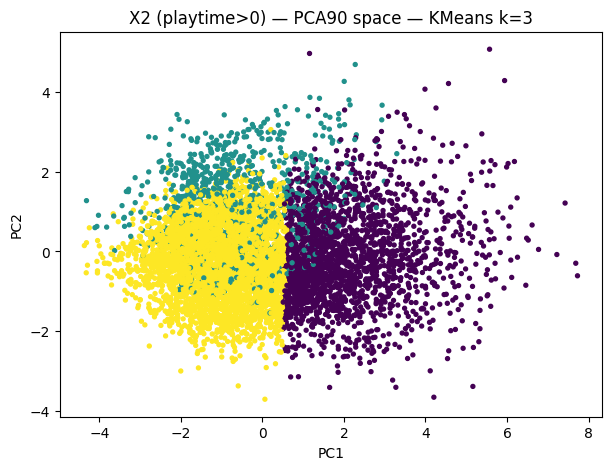

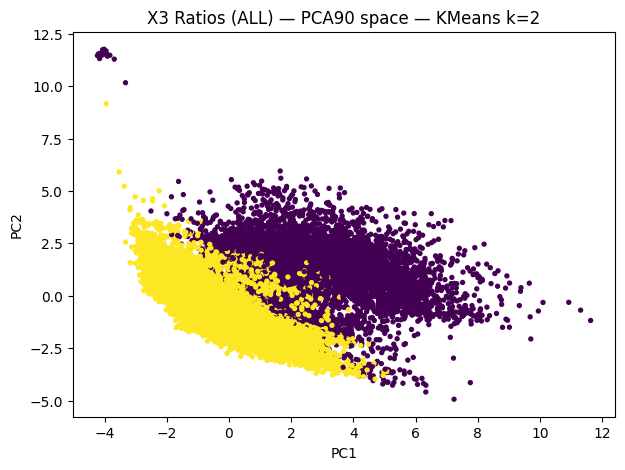

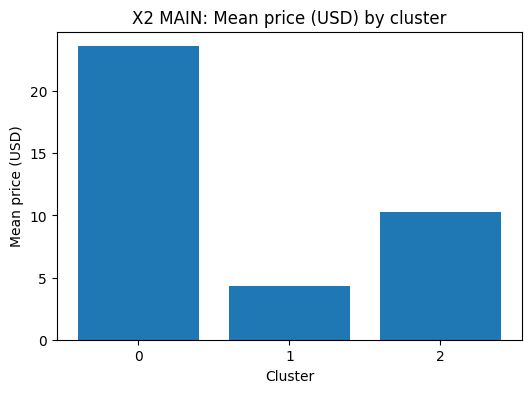

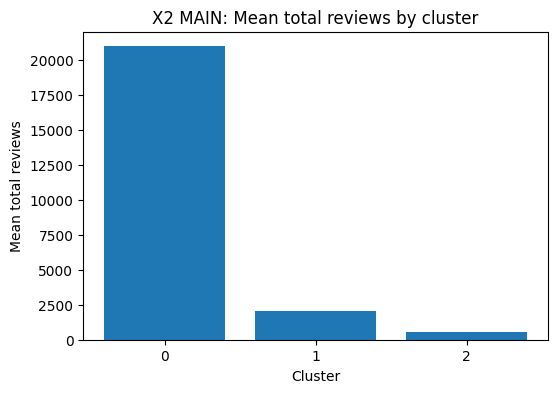

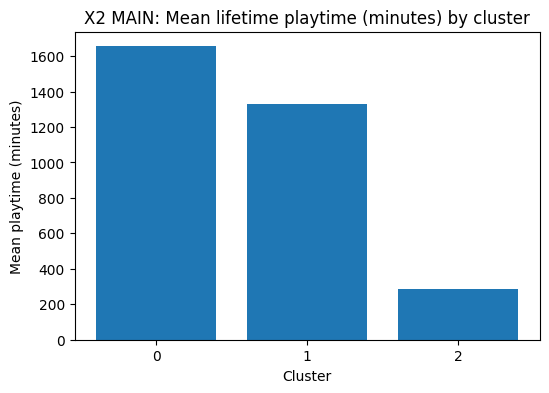

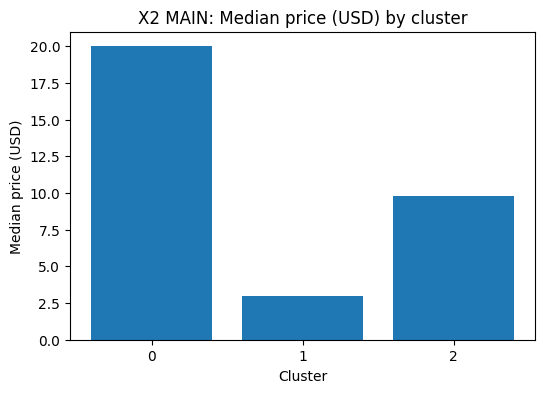

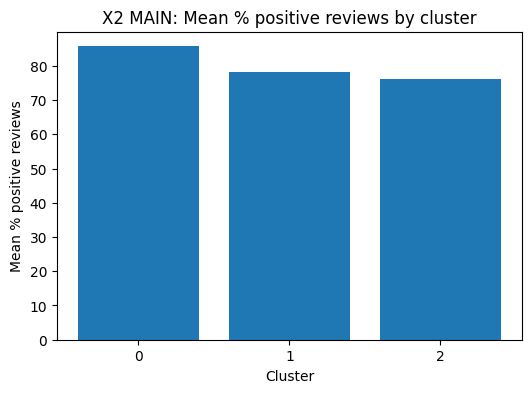

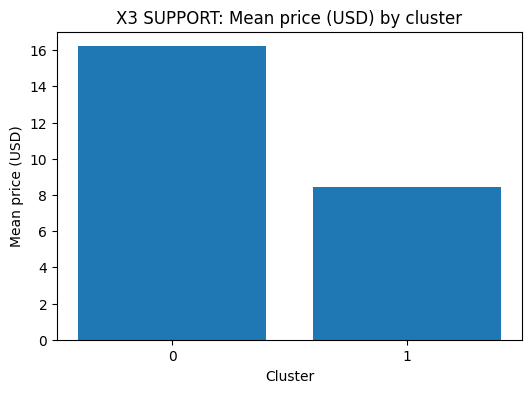

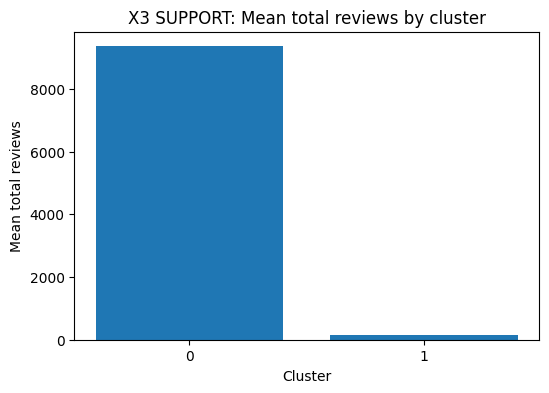

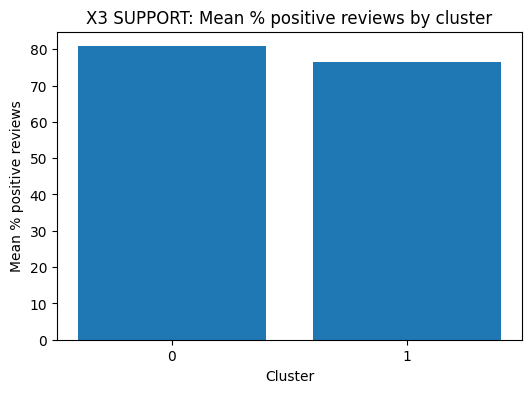

In [94]:
#X2
plt.figure(figsize=(7,5))
plt.scatter(X2_pca90[:,0], X2_pca90[:,1], c=df_pt["cluster_km3"], s=8)
plt.title("X2 (playtime>0) — PCA90 space — KMeans k=3")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#X3
plt.figure(figsize=(7,5))
plt.scatter(X3_pca90[:,0], X3_pca90[:,1], c=df_base["cluster_km2"], s=8)
plt.title("X3 Ratios (ALL) — PCA90 space — KMeans k=2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


def plot_cluster_means(df, cluster_col, feature, title, ylabel=None):
    vals = df.groupby(cluster_col)[feature].mean().sort_index()
    plt.figure(figsize=(6,4))
    plt.bar(vals.index.astype(str), vals.values)
    plt.title(title)
    plt.xlabel("Cluster")
    plt.ylabel(ylabel if ylabel else f"Mean {feature}")
    plt.show()

def plot_cluster_medians(df, cluster_col, feature, title, ylabel=None):
    vals = df.groupby(cluster_col)[feature].median().sort_index()
    plt.figure(figsize=(6,4))
    plt.bar(vals.index.astype(str), vals.values)
    plt.title(title)
    plt.xlabel("Cluster")
    plt.ylabel(ylabel if ylabel else f"Median {feature}")
    plt.show()
#MAIN (X2)
#mean charts
plot_cluster_means(df_pt, "cluster_km3", "price", "X2 MAIN: Mean price (USD) by cluster", ylabel="Mean price (USD)")
plot_cluster_means(df_pt, "cluster_km3", "num_reviews_total", "X2 MAIN: Mean total reviews by cluster", ylabel="Mean total reviews")
plot_cluster_means(df_pt, "cluster_km3", "average_playtime_forever",
                   "X2 MAIN: Mean lifetime playtime (minutes) by cluster",
                   ylabel="Mean playtime (minutes)")

#median price chart
plot_cluster_medians(df_pt, "cluster_km3", "price", "X2 MAIN: Median price (USD) by cluster", ylabel="Median price (USD)")

#pct positive chart
plot_cluster_means(df_pt, "cluster_km3", "pct_pos_total",
                   "X2 MAIN: Mean % positive reviews by cluster",
                   ylabel="Mean % positive reviews")
#SUPPORT (X3)
plot_cluster_means(df_base, "cluster_km2", "price", "X3 SUPPORT: Mean price (USD) by cluster", ylabel="Mean price (USD)")
plot_cluster_means(df_base, "cluster_km2", "num_reviews_total", "X3 SUPPORT: Mean total reviews by cluster", ylabel="Mean total reviews")
plot_cluster_means(df_base, "cluster_km2", "pct_pos_total",
                   "X3 SUPPORT: Mean % positive reviews by cluster",
                   ylabel="Mean % positive reviews")

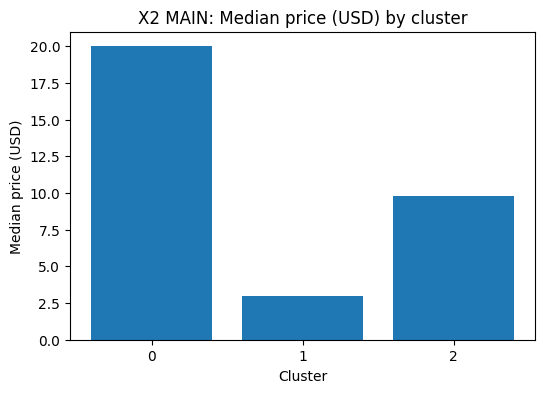

In [91]:
med_price = df_pt.groupby("cluster_km3")["price"].median().sort_index()

plt.figure(figsize=(6,4))
plt.bar(med_price.index.astype(str), med_price.values)
plt.title("X2 MAIN: Median price (USD) by cluster")
plt.xlabel("Cluster")
plt.ylabel("Median price (USD)")
plt.show()

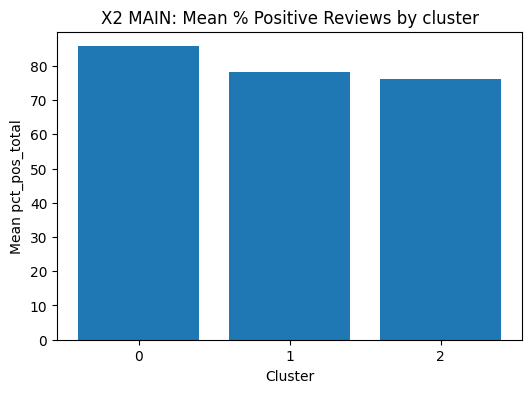

In [89]:
plot_cluster_means(df_pt, "cluster_km3", "pct_pos_total",
                   "X2 MAIN: Mean % Positive Reviews by cluster")

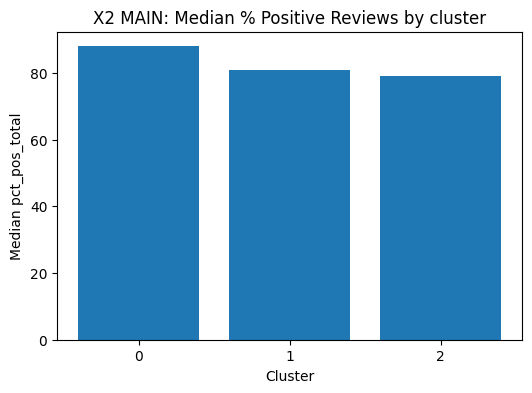

In [90]:
med = df_pt.groupby("cluster_km3")["pct_pos_total"].median().sort_index()

plt.figure(figsize=(6,4))
plt.bar(med.index.astype(str), med.values)
plt.title("X2 MAIN: Median % Positive Reviews by cluster")
plt.xlabel("Cluster")
plt.ylabel("Median pct_pos_total")
plt.show()

#**X2 KMeans k=3**

##Cluster 0 (31.45%)

*Popular premium games / high engagement*

Evidence:

- Mean price = $23.60

- Owners mean = 1.25M

- Reviews mean = 20,973

- Peak CCU mean = 1,470

- Avg playtime mean = 1,655 minutes (~27.6 hrs)

- Pct positive mean = 85.7%

*Top games are:
R6 Siege, Rust, Witcher 3, Elden Ring, Stardew Valley, BG3, etc.*

Cluster overview:

- High-quality, mainstream, heavily played games.



##Cluster 1 (12.96%)

*Discount-driven games (sale purchases)*

Evidence:

- Mean price = $4.30

- Mean discount = 67.3% (INSANE)

- Mean owners = 207k

- Mean reviews = 2,018

- Avg playtime mean = 1,329 minutes (~22 hrs)

Cluster overview:

- This is perfect for value-for-money theme.



##Cluster 2 (55.59%)

*Low-engagement / niche / low visibility games*

Evidence:

- Mean price = $10.28

- Mean discount = 0.47% (almost no discounts)

- Mean owners = 108k

- Mean reviews = 552

- Peak CCU mean = 4.97

- Avg playtime mean = 284 minutes (~4.7 hrs)

*Example games:
Refunct, Zup!, A Bird Story, etc.*

Cluster overview:

- Games that exist, but don’t get played much.

####X3 doesn’t really create “3–5 meaningful gamer segments”.

Instead, it very clearly separates:

Cluster 0 (20%)
- Market winners
- High-traction / proven games
Higher owners, reviews, peak CCU, and non-zero playtime. This is where the big well-known titles fall.

Cluster 1 (80%)
- Market non-winners / low-signal games
- Low-traction / low-signal games
Much lower owners/reviews/CCU, and median playtime is 0, meaning many games have missing or zero playtime records.


*So X3 is used as a supporting result showing a clear “market winners vs low-visibility” separation, while X2 remains the main model for real engagement (playtime>0)*